In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import shap

from torch import nn
from torch_geometric.nn import MLP
from torch.optim import Adam
from torch.nn.functional import cross_entropy

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import seaborn

from torch_geometric.nn.aggr.deep_sets import DeepSetsAggregation
#from modifieddeepset import DeepSetsAggregation


from itertools import product # for hyperparameter grid search

torch.manual_seed(123)

In [25]:
train = pd.read_csv('csv_files_harmonized/train.csv') # balanced?
test = pd.read_csv('csv_files_harmonized/test.csv')
val = pd.read_csv('csv_files_harmonized/val.csv')

In [27]:
print(train.shape, test.shape, val.shape)

(5567103, 74) (2680727, 74) (2963870, 74)


In [28]:
train.isnull().sum()

Amplitude    0
190BCKG      0
138Ba        0
CD16         0
111Cd        0
            ..
CD135        0
CD56         0
Time         0
id           0
group        0
Length: 74, dtype: int64

In [29]:
train.columns

Index(['Amplitude', '190BCKG', '138Ba', 'CD16', '111Cd', 'CD4', 'CD14', 'CD19',
       'CD3', '140Ce', 'Center', '133Cs', 'CD235ab', 'CD11c', 'CD33', 'CD133',
       'CD123', 'CD162', 'CD185', 'CD45RA', 'CD278', 'CD194', 'Event_length',
       'CD161', 'CD184', '157Gd', 'CD27', 'CD44', '177Hf', '178Hf', 'CD127',
       '127I', '115In', '191Ir', '193Ir', 'CD10', 'CD73', 'HLA-DR', 'CD146',
       'CD117', 'CD8a', 'CD34', 'CD105', 'Offset', '208Pb', '102Pd', '104Pd',
       '105Pd', '106Pd', '108Pd', '110Pd', 'CD49d', '194Pt', '195Pt', '198Pt',
       'Residual', '103Rh', 'CD20', 'CD25', 'CD66b', 'CD49f', '120Sn',
       'CD45RO', 'CD90', '131Xe', 'CD45', 'CD195', 'CD38', 'CD196', 'CD135',
       'CD56', 'Time', 'id', 'group'],
      dtype='object')

We are only using the markers that start with CD + HLA-DR

In [30]:
marker_columns = [col for col in train.columns if col.startswith('CD') or col.startswith('HLA-DR')]
marker_columns

['CD16',
 'CD4',
 'CD14',
 'CD19',
 'CD3',
 'CD235ab',
 'CD11c',
 'CD33',
 'CD133',
 'CD123',
 'CD162',
 'CD185',
 'CD45RA',
 'CD278',
 'CD194',
 'CD161',
 'CD184',
 'CD27',
 'CD44',
 'CD127',
 'CD10',
 'CD73',
 'HLA-DR',
 'CD146',
 'CD117',
 'CD8a',
 'CD34',
 'CD105',
 'CD49d',
 'CD20',
 'CD25',
 'CD66b',
 'CD49f',
 'CD45RO',
 'CD90',
 'CD45',
 'CD195',
 'CD38',
 'CD196',
 'CD135',
 'CD56']

In [32]:
train[marker_columns] = np.arcsinh(train[marker_columns]/5)
test[marker_columns] = np.arcsinh(test[marker_columns]/5)
val[marker_columns] = np.arcsinh(val[marker_columns]/5)

In [34]:
train['group'] = train['group'].map({'baseline': 0, 'post': 1, 'healthy': 2})
test['group'] = test['group'].map({'baseline': 0, 'post': 1, 'healthy': 2})
val['group'] = val['group'].map({'baseline': 0, 'post': 1, 'healthy': 2})

In [35]:
train['group'].value_counts()

group
0    1855701
2    1855701
1    1855701
Name: count, dtype: int64

In [36]:
for i in [train, test, val]:
    i['id_split'] = i['id']
    i.loc[i['group'] == 1, 'id_split'] = i.loc[i['group'] == 1, 'id'] + '_post'

In [37]:
train['id_numeric'], train_id_mapping = pd.factorize(train['id_split'])
test['id_numeric'], test_id_mapping = pd.factorize(test['id_split'])
val['id_numeric'], val_id_mapping = pd.factorize(val['id_split'])

In [38]:
features = torch.tensor(train[marker_columns].values, dtype=torch.float)
labels = torch.tensor(train['group'].values, dtype=torch.long)
id_splits = torch.tensor(train['id_numeric'].values, dtype=torch.long)

In [39]:
unique_id_splits = torch.unique(id_splits)
id_to_batch = {id_val.item(): i for i, id_val in enumerate(unique_id_splits)}
batch_indices = torch.tensor([id_to_batch[id_val.item()] for id_val in id_splits], dtype=torch.long)

val_unique_id_splits = torch.tensor(val['id_numeric'].unique(), dtype=torch.long)

In [40]:
def initialize_model(features, local_hidden_sizes, global_hidden_sizes, dropout):
    local_mlp = MLP([features.shape[1]] + local_hidden_sizes, dropout=dropout)
    global_hidden_sizes = [local_hidden_sizes[-1]] + global_hidden_sizes + [3]
    global_mlp = MLP(global_hidden_sizes, dropout=dropout)
    
    return DeepSetsAggregation(local_mlp, global_mlp)

In [41]:
def evaluate_loss(aggregation, features, index, labels, id_splits, val_unique_id_splits):
    aggregation.eval()
    with torch.no_grad():
        batch_predictions = aggregation(features, index=index)

        batch_predictions = batch_predictions[val_unique_id_splits]

        batch_labels = torch.tensor(
            [labels[id_splits == id_val].mode().values.item() for id_val in val_unique_id_splits],
            dtype=torch.long
        )

        loss = cross_entropy(batch_predictions, batch_labels)

    return loss.item()


In [42]:
def evaluate_patient_accuracy(aggregation, features, index, labels, id_splits, val_unique_id_splits):
    aggregation.eval()
    with torch.no_grad():
        batch_predictions = aggregation(features, index=index)

        batch_predictions = batch_predictions[val_unique_id_splits]

        predicted_classes = batch_predictions.argmax(dim=1)

        batch_labels = torch.tensor(
            [labels[id_splits == id_val].mode().values.item() for id_val in val_unique_id_splits],
            dtype=torch.long
        )

        correct_preds = (predicted_classes == batch_labels).sum().item()
        accuracy = correct_preds / len(val_unique_id_splits)  

    return accuracy


In [43]:
def train_model(local_hidden_sizes, global_hidden_sizes, dropout, lr, epochs, print_epoch=False):
    deepsetaggregation = initialize_model(features, local_hidden_sizes, global_hidden_sizes, dropout)
    optimizer = Adam(deepsetaggregation.parameters(), lr=lr)

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        deepsetaggregation.train()
        optimizer.zero_grad()
        batch_predictions = deepsetaggregation(features, index=batch_indices)

        batch_labels = torch.tensor(
            [labels[id_splits == id_val].mode().values.item() for id_val in unique_id_splits],
            dtype=torch.long
        )

        train_loss = cross_entropy(batch_predictions, batch_labels)
        train_loss.backward()
        optimizer.step()

        val_loss = evaluate_loss(deepsetaggregation, features, batch_indices, labels, id_splits, val_unique_id_splits)
        val_patient_accuracy = evaluate_patient_accuracy(deepsetaggregation, features, batch_indices, labels, id_splits, val_unique_id_splits)

        train_losses.append(train_loss.item())
        val_losses.append(val_loss)

        if print_epoch:
            print(f'Epoch: {epoch}, Train Loss: {train_loss.item()}, Val Loss: {val_loss}, Val accuracy per patient: {val_patient_accuracy}')

    return train_losses, val_losses, val_patient_accuracy, deepsetaggregation

In [44]:
learning_rates = [0.001, 0.005, 0.01] 
local_hidden_layer_sizes = [
    [16],
    [32]               
]
global_hidden_layer_sizes = [
    [8],       
    [4],          
]
dropout_rates = [0.0, 0.1]
epochs_list = [10, 20, 30]
results = []

combination: LR=0.001, Local hidden layers=[16], Global hidden layers [16, 8], Dropout=0.0, Epochs=10
Final val accuracy: 0.4444444444444444


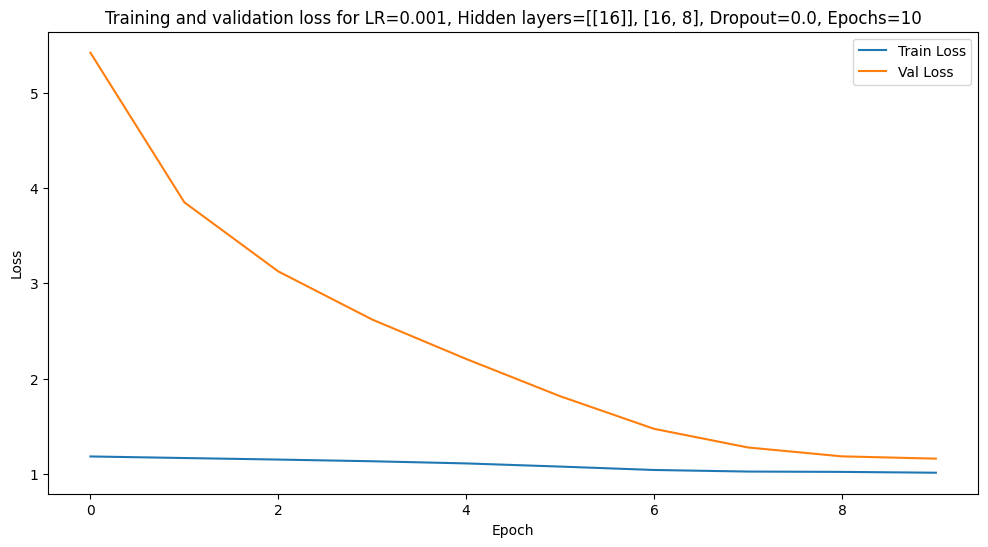

combination: LR=0.001, Local hidden layers=[16], Global hidden layers [16, 8], Dropout=0.0, Epochs=20
Final val accuracy: 1.0


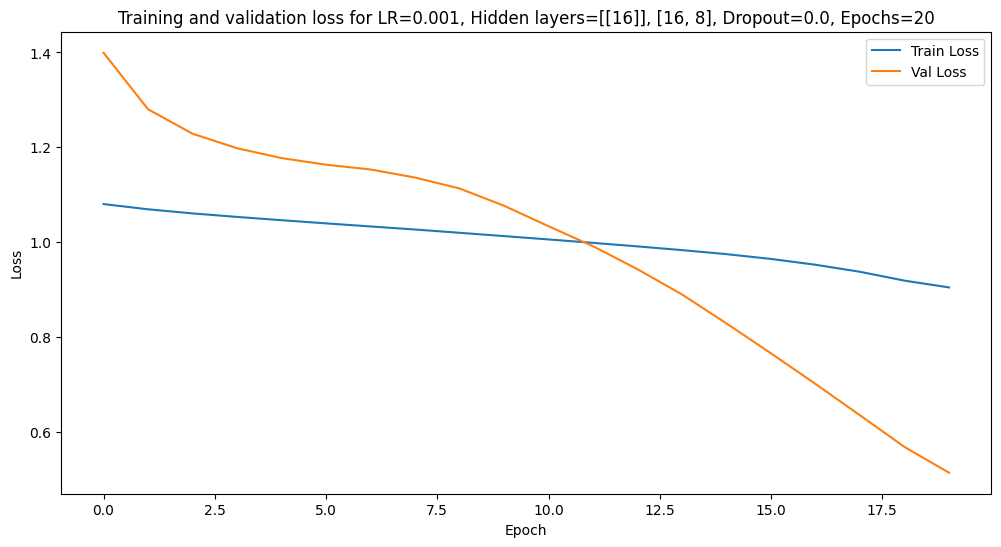

combination: LR=0.001, Local hidden layers=[16], Global hidden layers [16, 8], Dropout=0.0, Epochs=30
Final val accuracy: 1.0


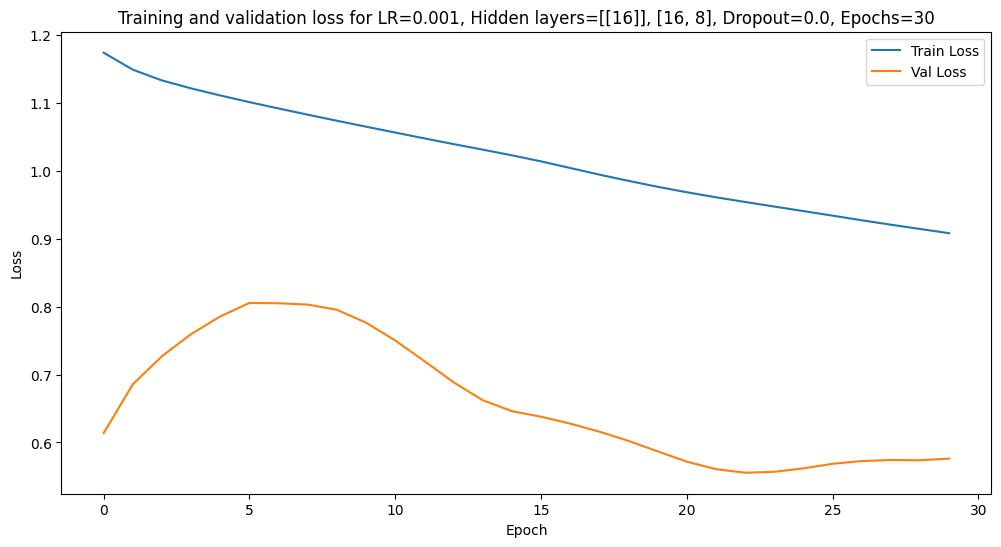

combination: LR=0.001, Local hidden layers=[16], Global hidden layers [16, 8], Dropout=0.1, Epochs=10
Final val accuracy: 1.0


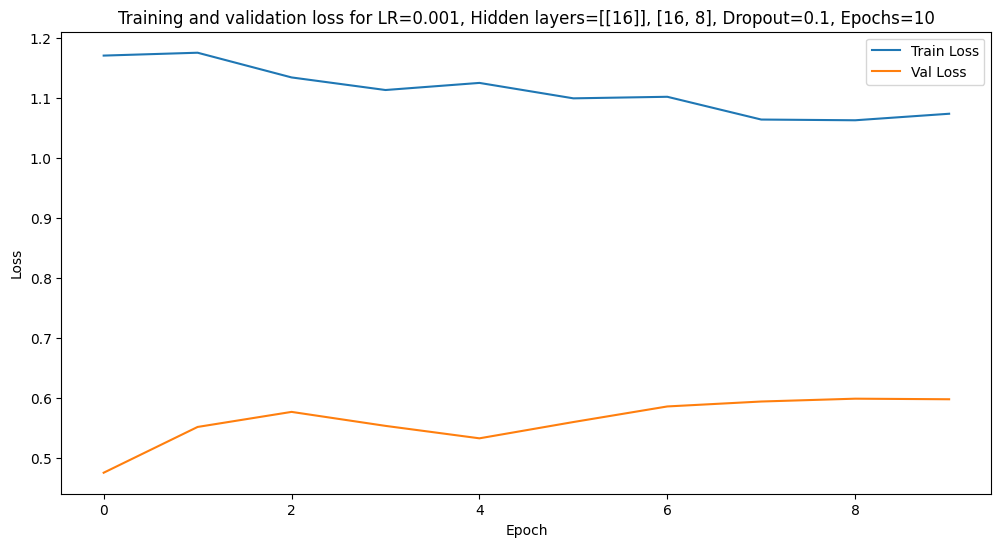

combination: LR=0.001, Local hidden layers=[16], Global hidden layers [16, 8], Dropout=0.1, Epochs=20
Final val accuracy: 0.8888888888888888


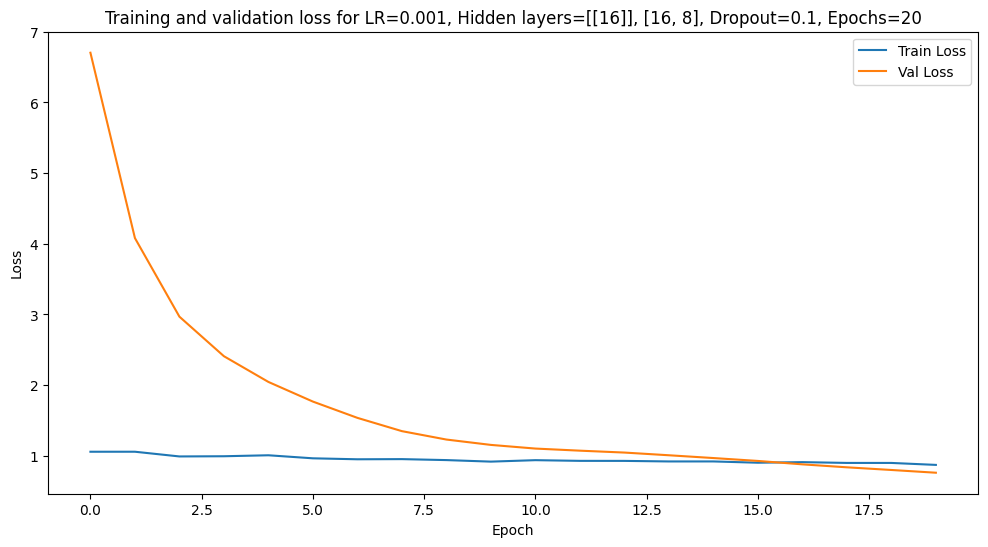

combination: LR=0.001, Local hidden layers=[16], Global hidden layers [16, 8], Dropout=0.1, Epochs=30
Final val accuracy: 1.0


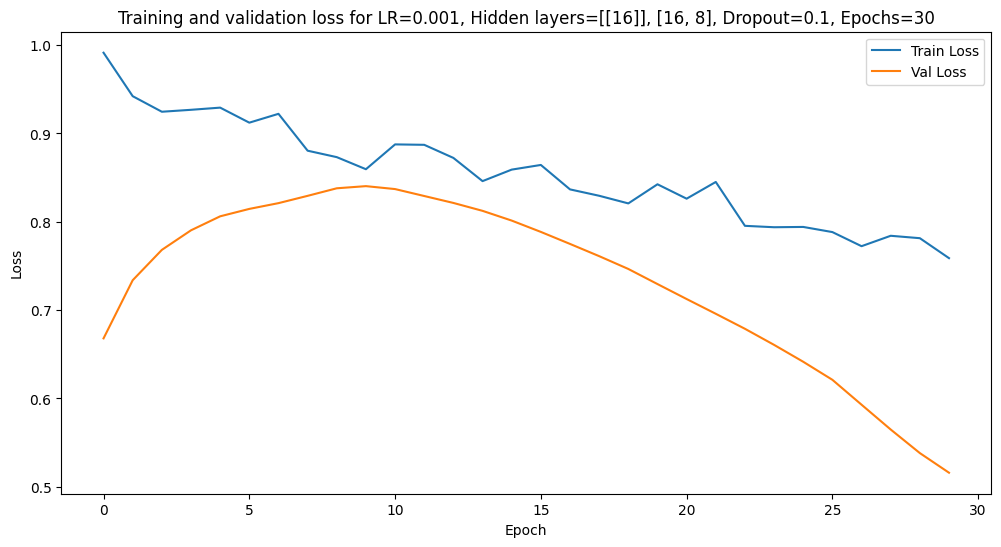

combination: LR=0.001, Local hidden layers=[16], Global hidden layers [16, 4], Dropout=0.0, Epochs=10
Final val accuracy: 0.2222222222222222


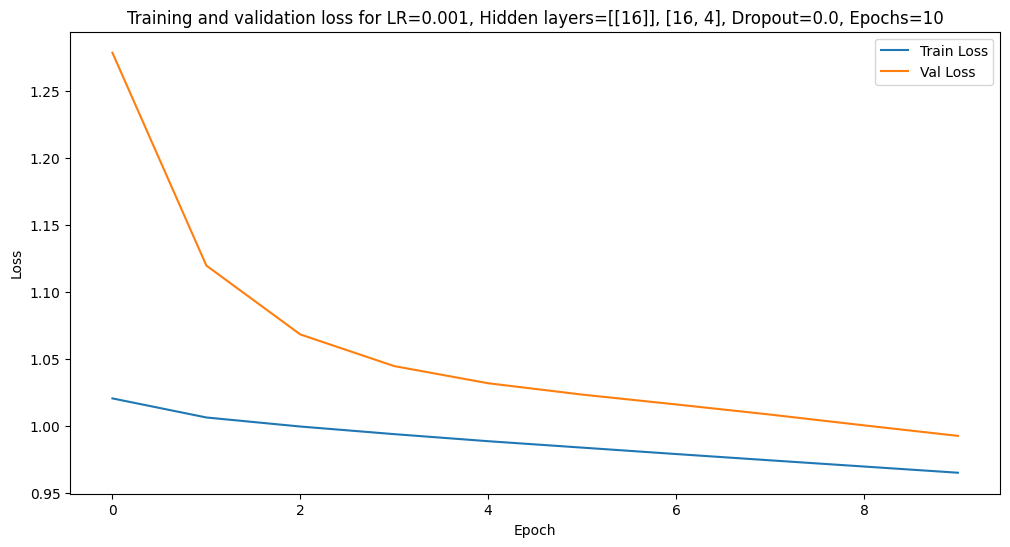

combination: LR=0.001, Local hidden layers=[16], Global hidden layers [16, 4], Dropout=0.0, Epochs=20
Final val accuracy: 0.0


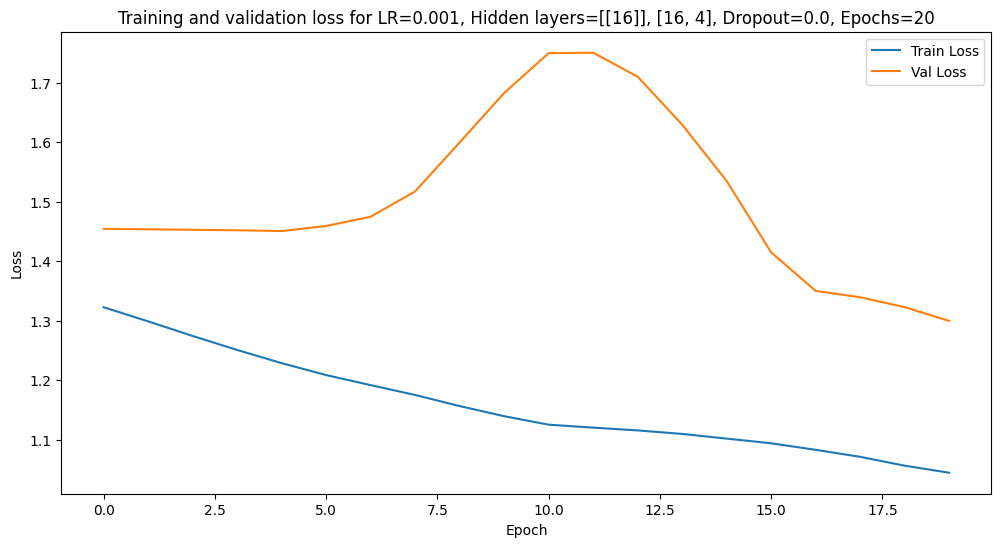

combination: LR=0.001, Local hidden layers=[16], Global hidden layers [16, 4], Dropout=0.0, Epochs=30
Final val accuracy: 0.5555555555555556


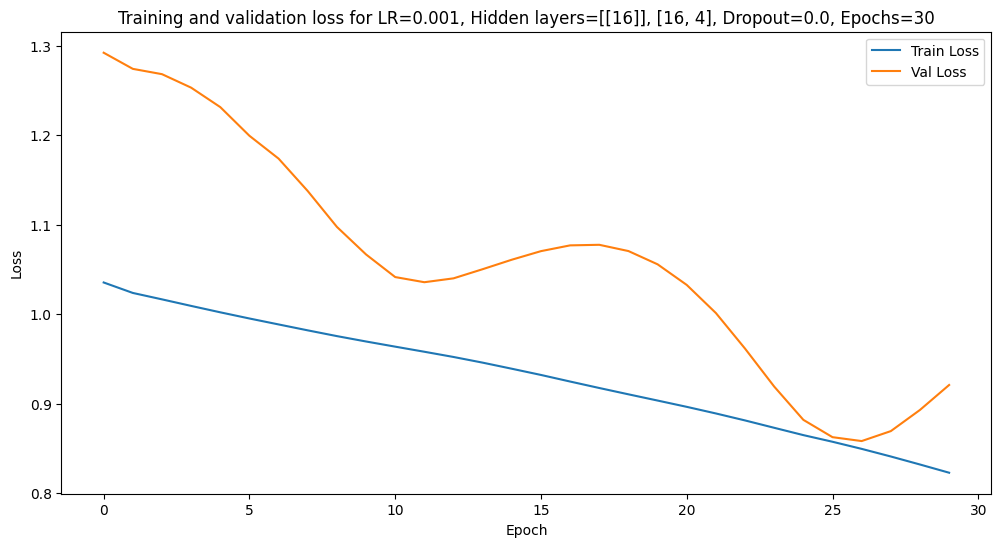

combination: LR=0.001, Local hidden layers=[16], Global hidden layers [16, 4], Dropout=0.1, Epochs=10
Final val accuracy: 0.8888888888888888


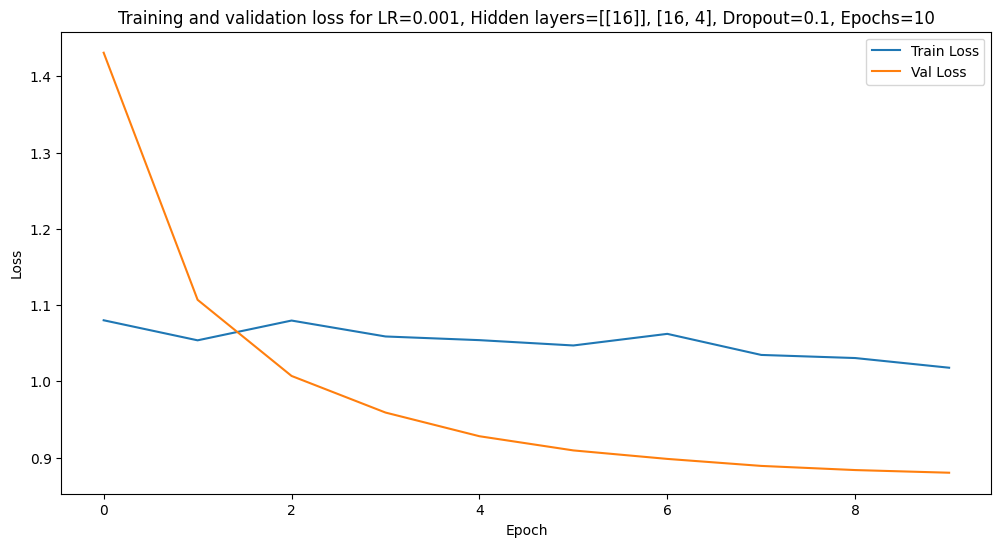

combination: LR=0.001, Local hidden layers=[16], Global hidden layers [16, 4], Dropout=0.1, Epochs=20
Final val accuracy: 1.0


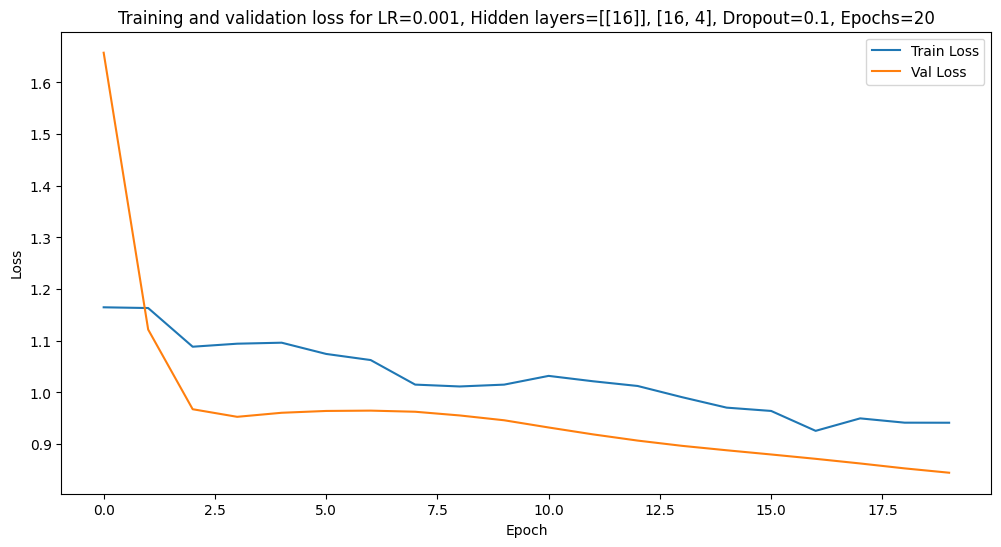

combination: LR=0.001, Local hidden layers=[16], Global hidden layers [16, 4], Dropout=0.1, Epochs=30
Final val accuracy: 0.0


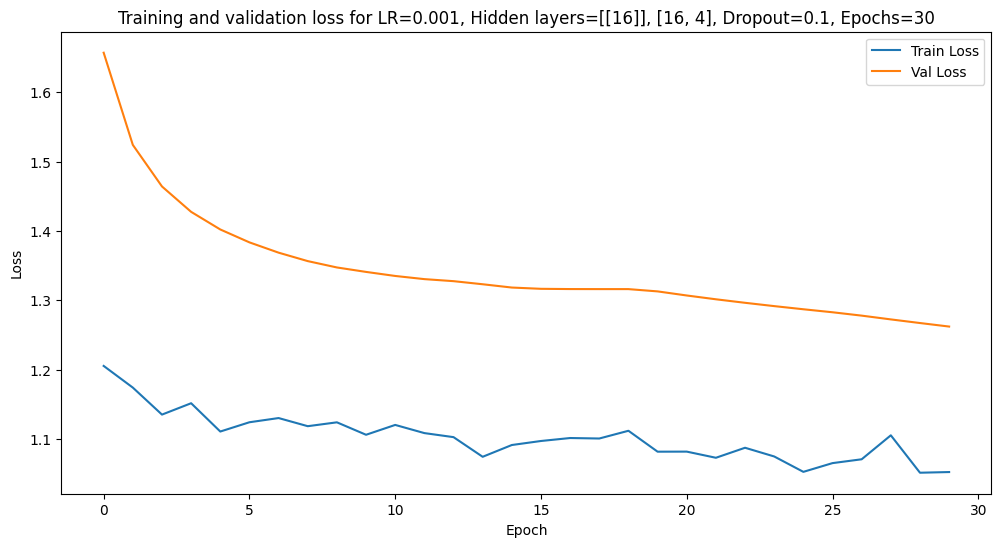

combination: LR=0.001, Local hidden layers=[32], Global hidden layers [32, 8], Dropout=0.0, Epochs=10
Final val accuracy: 1.0


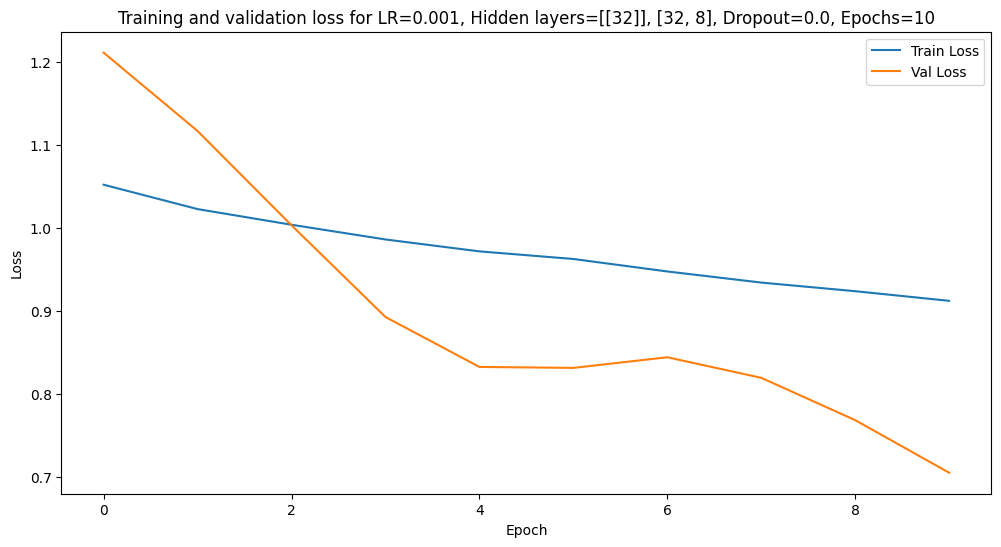

combination: LR=0.001, Local hidden layers=[32], Global hidden layers [32, 8], Dropout=0.0, Epochs=20
Final val accuracy: 1.0


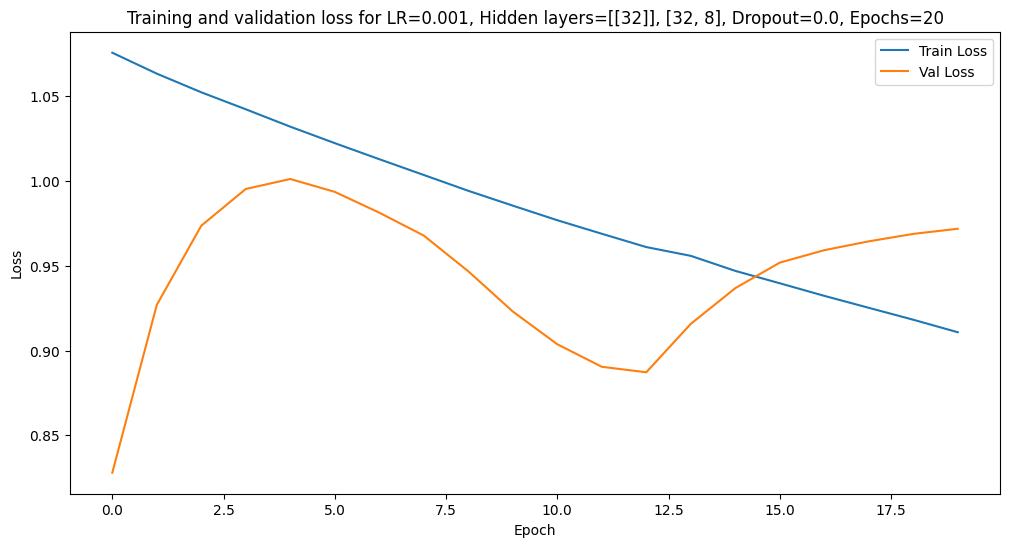

combination: LR=0.001, Local hidden layers=[32], Global hidden layers [32, 8], Dropout=0.0, Epochs=30
Final val accuracy: 0.0


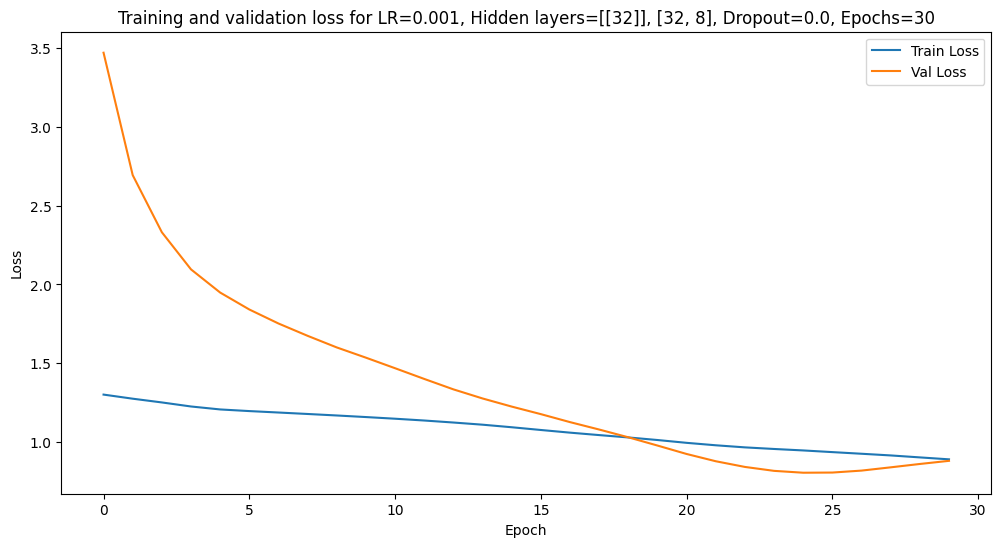

combination: LR=0.001, Local hidden layers=[32], Global hidden layers [32, 8], Dropout=0.1, Epochs=10
Final val accuracy: 0.2222222222222222


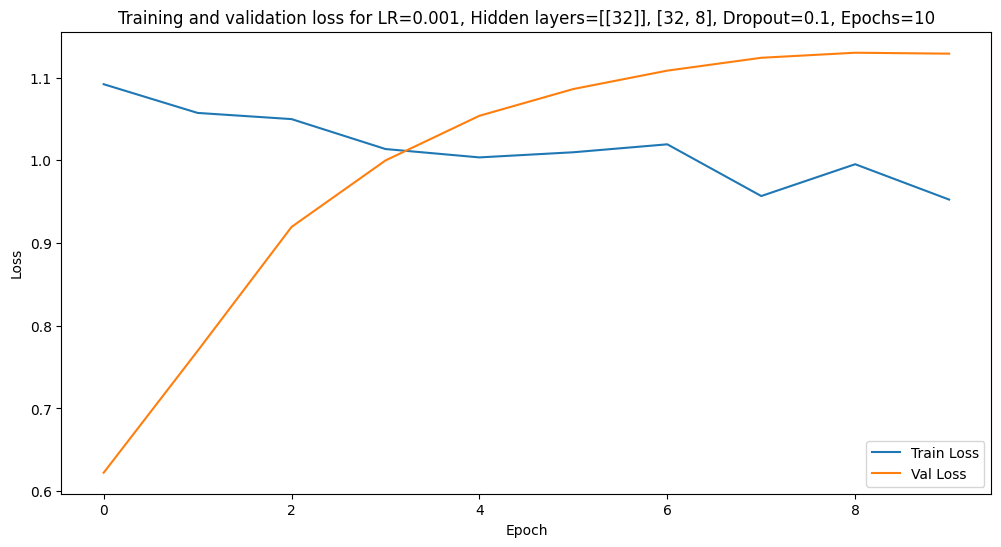

combination: LR=0.001, Local hidden layers=[32], Global hidden layers [32, 8], Dropout=0.1, Epochs=20
Final val accuracy: 0.7777777777777778


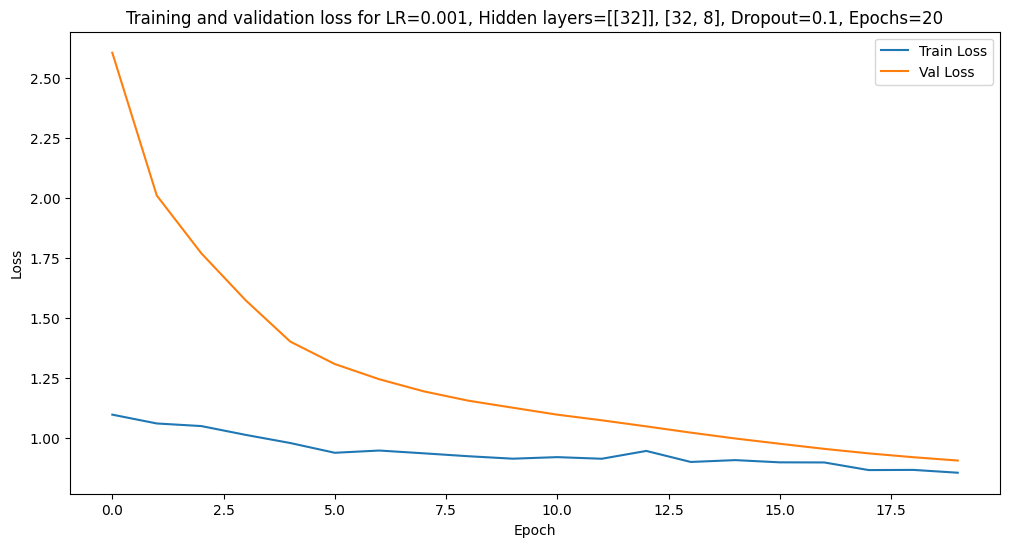

combination: LR=0.001, Local hidden layers=[32], Global hidden layers [32, 8], Dropout=0.1, Epochs=30
Final val accuracy: 1.0


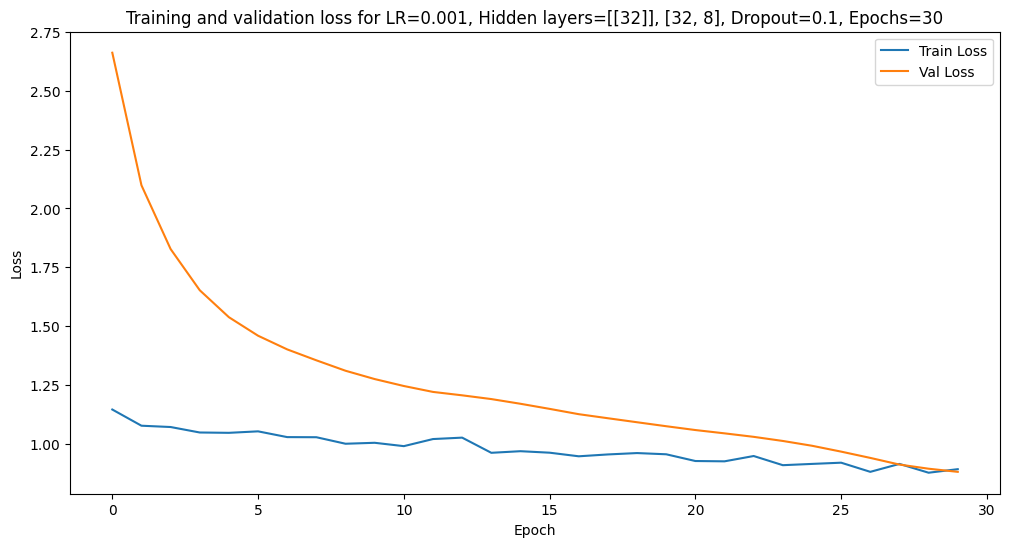

combination: LR=0.001, Local hidden layers=[32], Global hidden layers [32, 4], Dropout=0.0, Epochs=10
Final val accuracy: 1.0


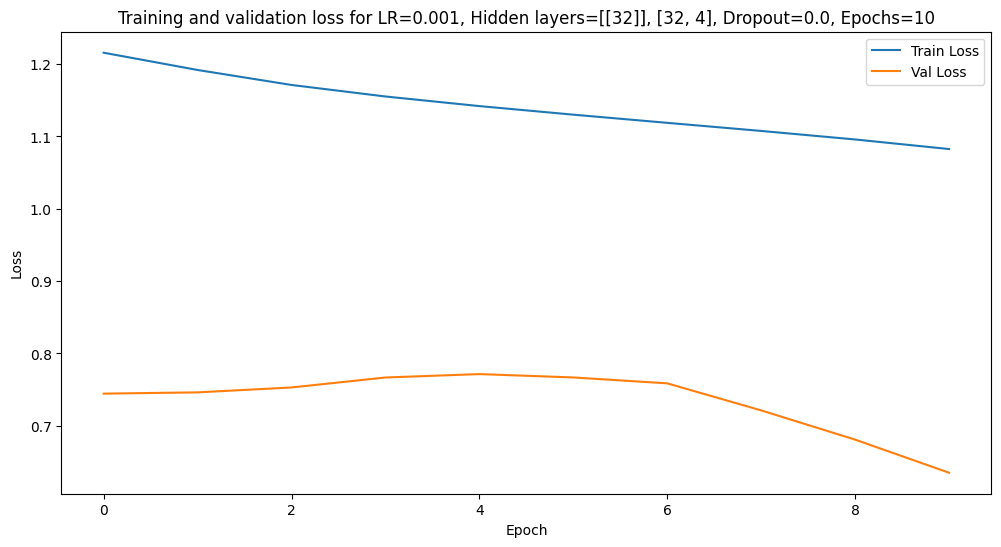

combination: LR=0.001, Local hidden layers=[32], Global hidden layers [32, 4], Dropout=0.0, Epochs=20
Final val accuracy: 0.5555555555555556


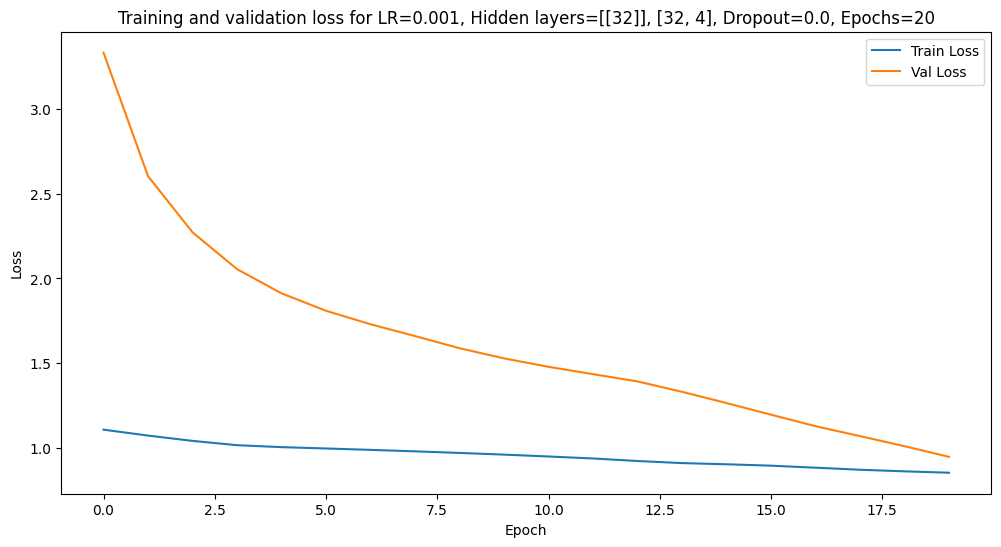

combination: LR=0.001, Local hidden layers=[32], Global hidden layers [32, 4], Dropout=0.0, Epochs=30
Final val accuracy: 0.0


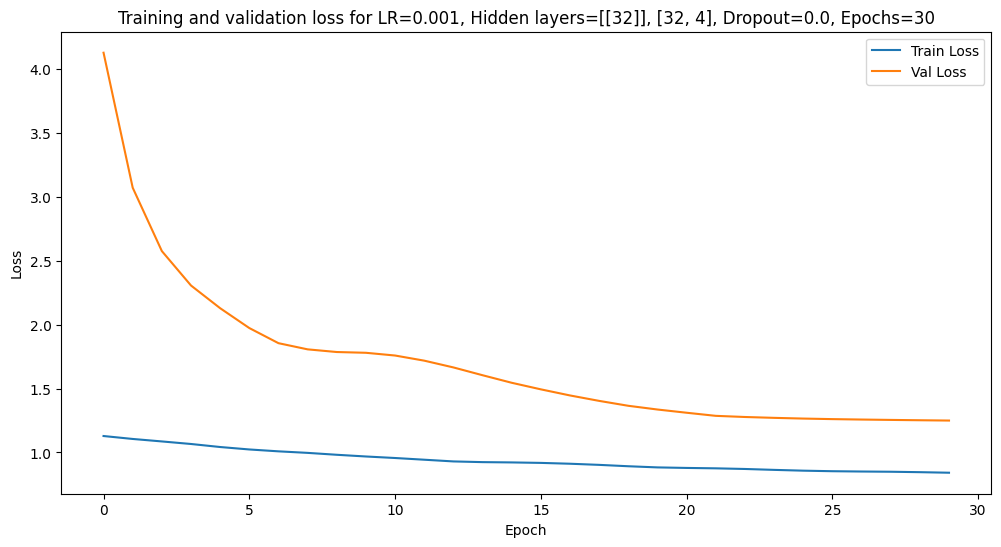

combination: LR=0.001, Local hidden layers=[32], Global hidden layers [32, 4], Dropout=0.1, Epochs=10
Final val accuracy: 0.7777777777777778


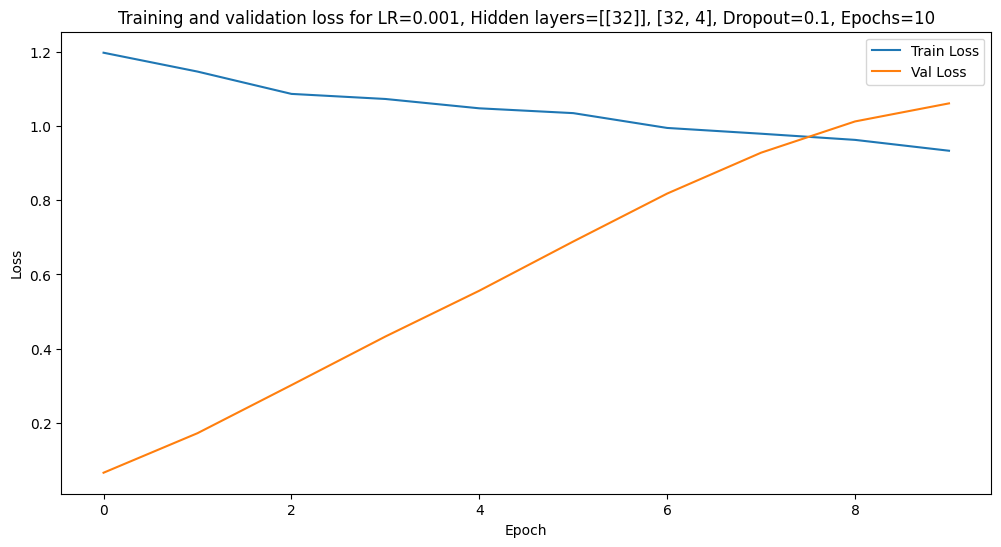

combination: LR=0.001, Local hidden layers=[32], Global hidden layers [32, 4], Dropout=0.1, Epochs=20
Final val accuracy: 0.0


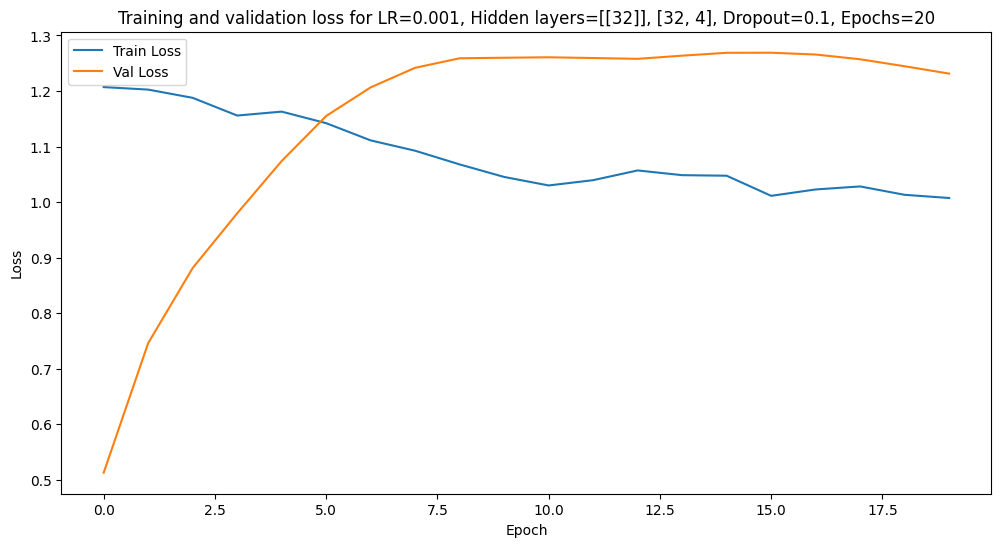

combination: LR=0.001, Local hidden layers=[32], Global hidden layers [32, 4], Dropout=0.1, Epochs=30
Final val accuracy: 0.8888888888888888


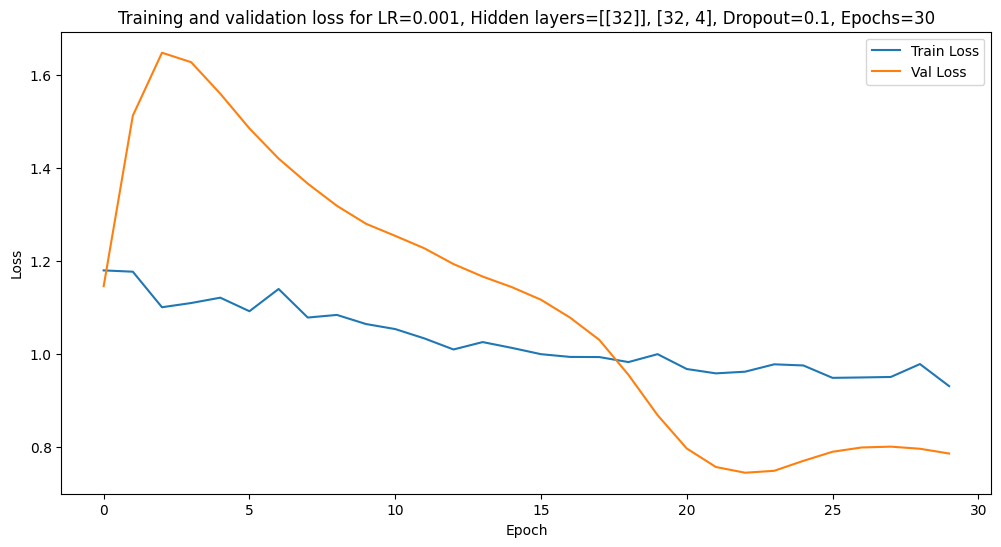

combination: LR=0.005, Local hidden layers=[16], Global hidden layers [16, 8], Dropout=0.0, Epochs=10
Final val accuracy: 0.8888888888888888


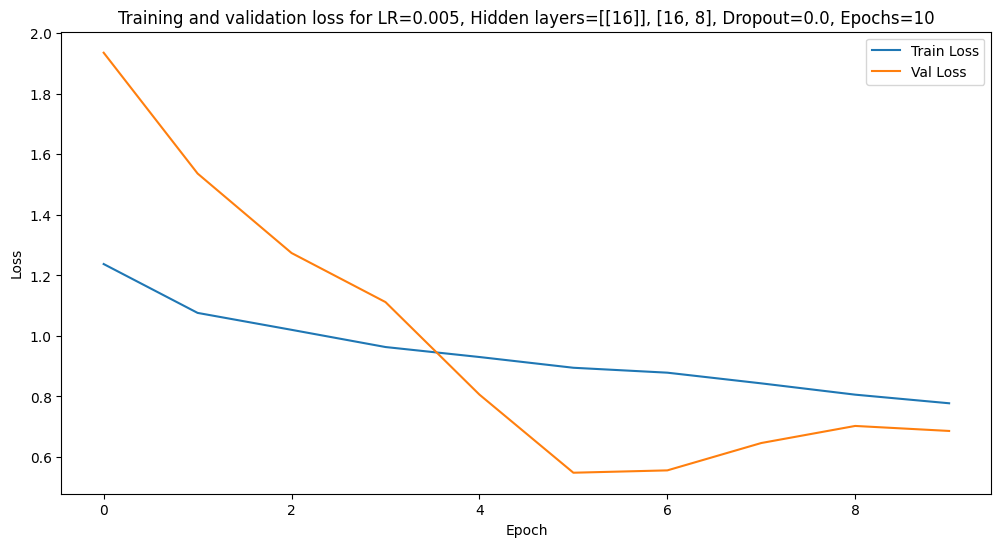

combination: LR=0.005, Local hidden layers=[16], Global hidden layers [16, 8], Dropout=0.0, Epochs=20
Final val accuracy: 1.0


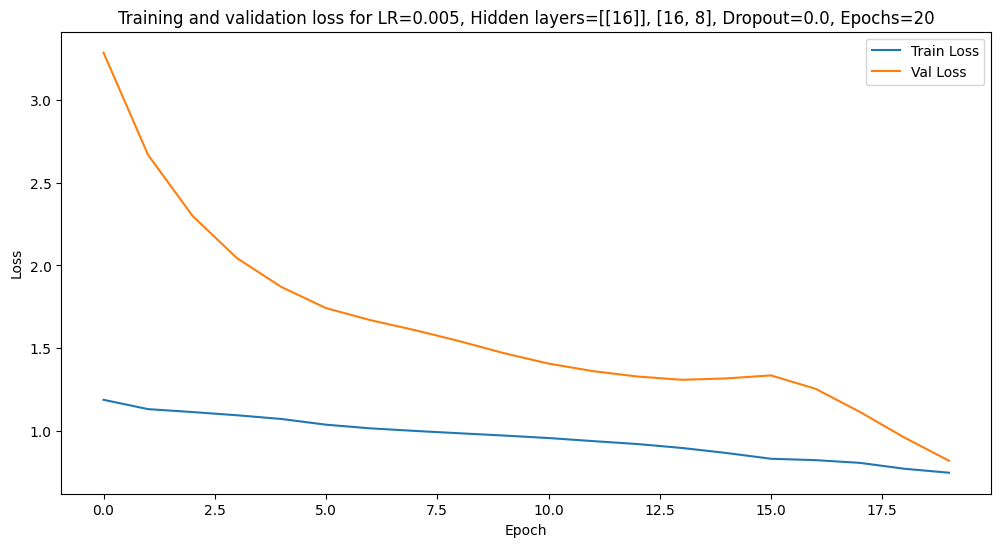

combination: LR=0.005, Local hidden layers=[16], Global hidden layers [16, 8], Dropout=0.0, Epochs=30
Final val accuracy: 1.0


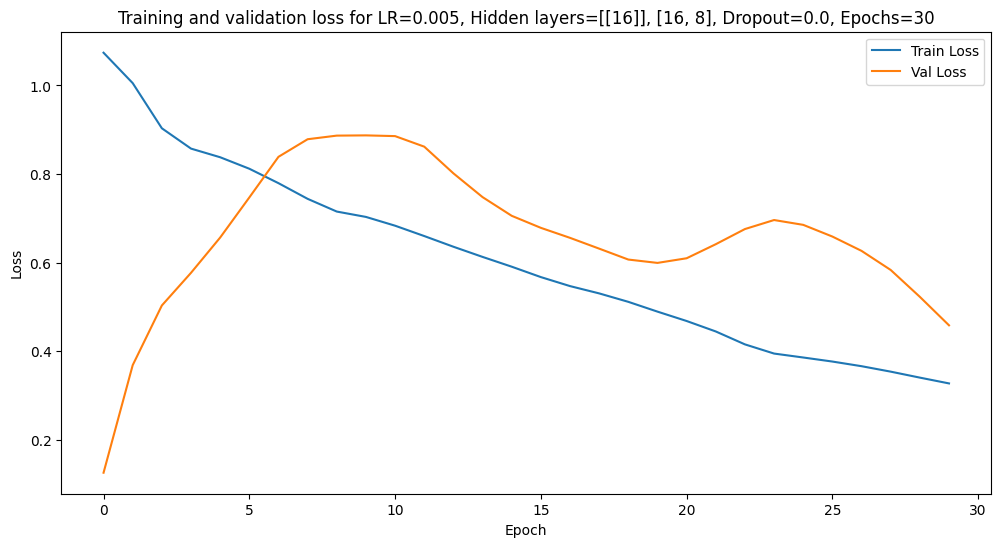

combination: LR=0.005, Local hidden layers=[16], Global hidden layers [16, 8], Dropout=0.1, Epochs=10
Final val accuracy: 0.8888888888888888


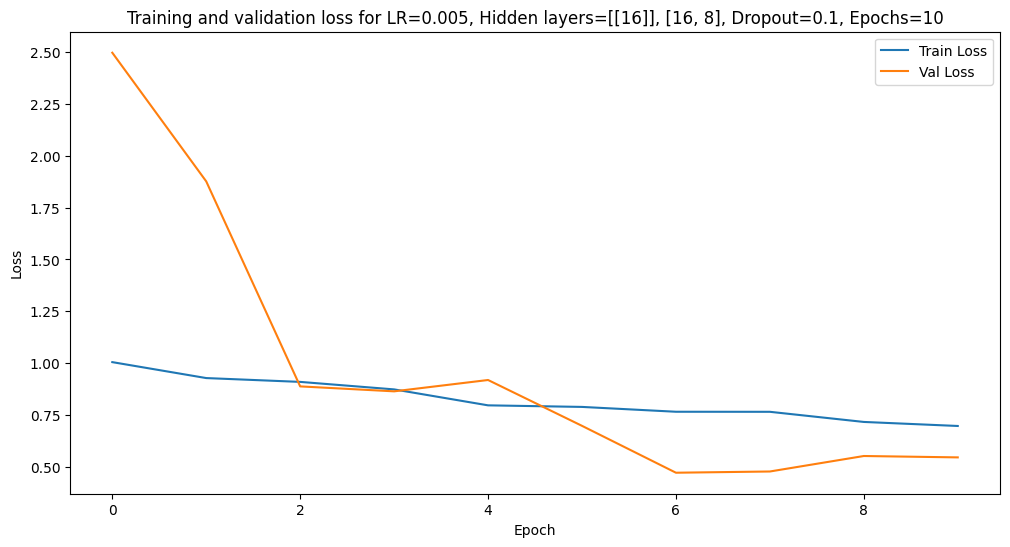

combination: LR=0.005, Local hidden layers=[16], Global hidden layers [16, 8], Dropout=0.1, Epochs=20
Final val accuracy: 1.0


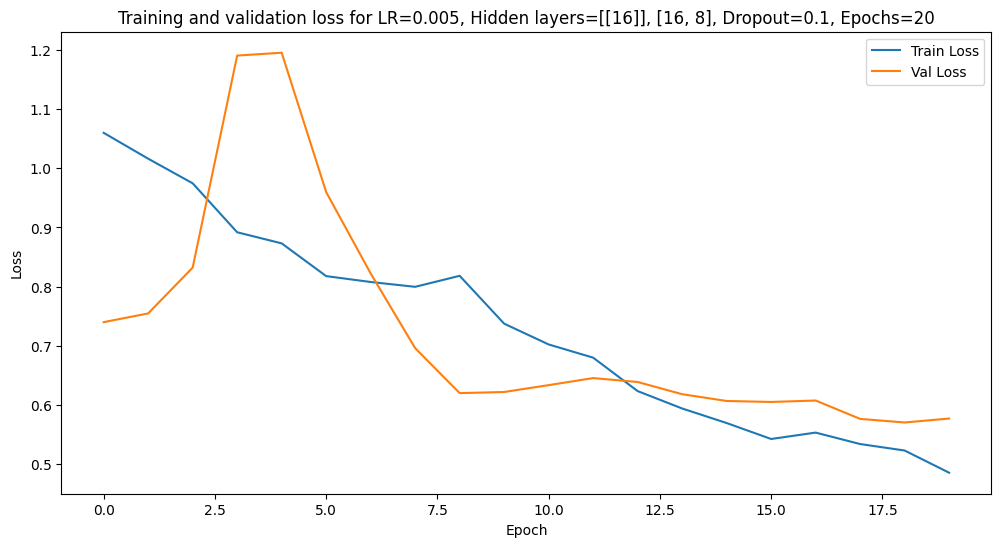

combination: LR=0.005, Local hidden layers=[16], Global hidden layers [16, 8], Dropout=0.1, Epochs=30
Final val accuracy: 1.0


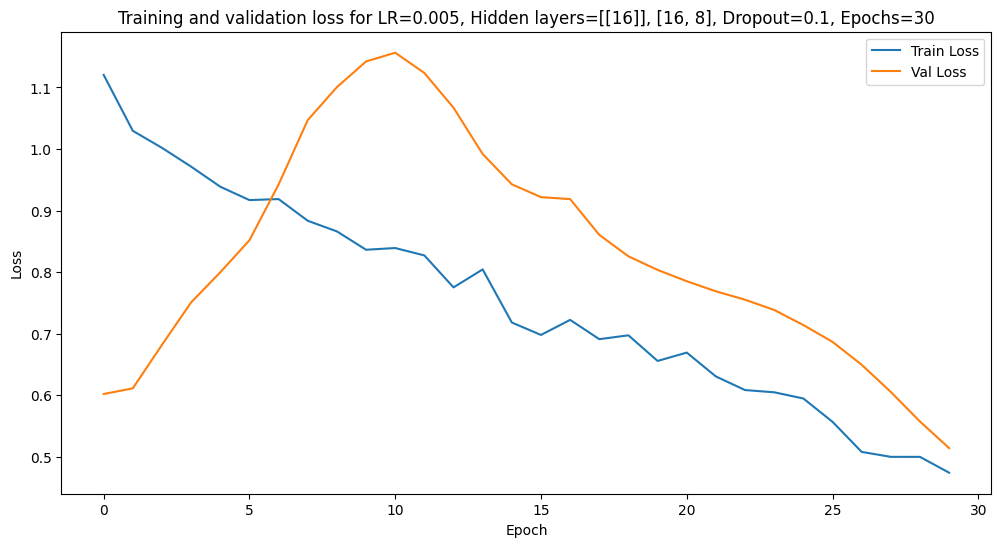

combination: LR=0.005, Local hidden layers=[16], Global hidden layers [16, 4], Dropout=0.0, Epochs=10
Final val accuracy: 0.0


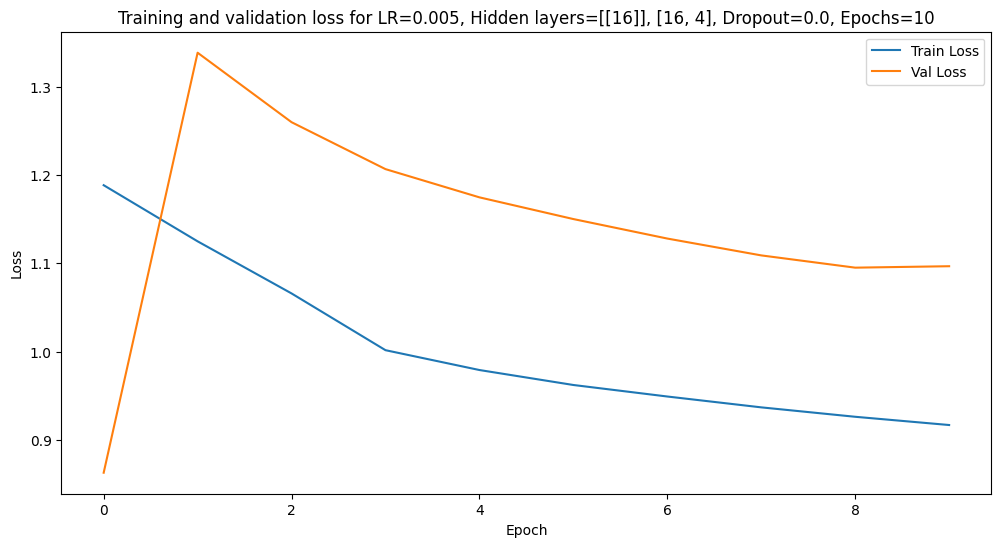

combination: LR=0.005, Local hidden layers=[16], Global hidden layers [16, 4], Dropout=0.0, Epochs=20
Final val accuracy: 1.0


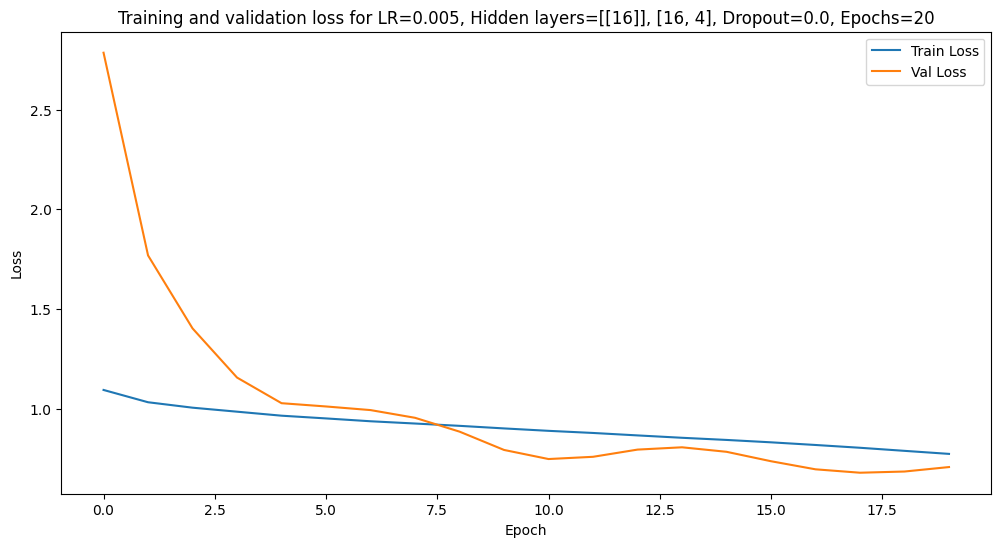

combination: LR=0.005, Local hidden layers=[16], Global hidden layers [16, 4], Dropout=0.0, Epochs=30
Final val accuracy: 0.0


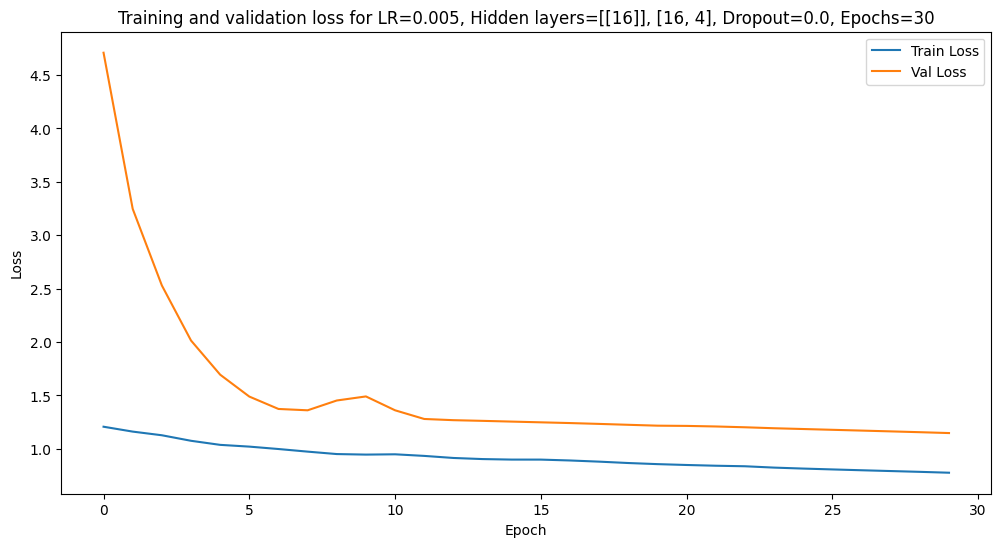

combination: LR=0.005, Local hidden layers=[16], Global hidden layers [16, 4], Dropout=0.1, Epochs=10
Final val accuracy: 0.1111111111111111


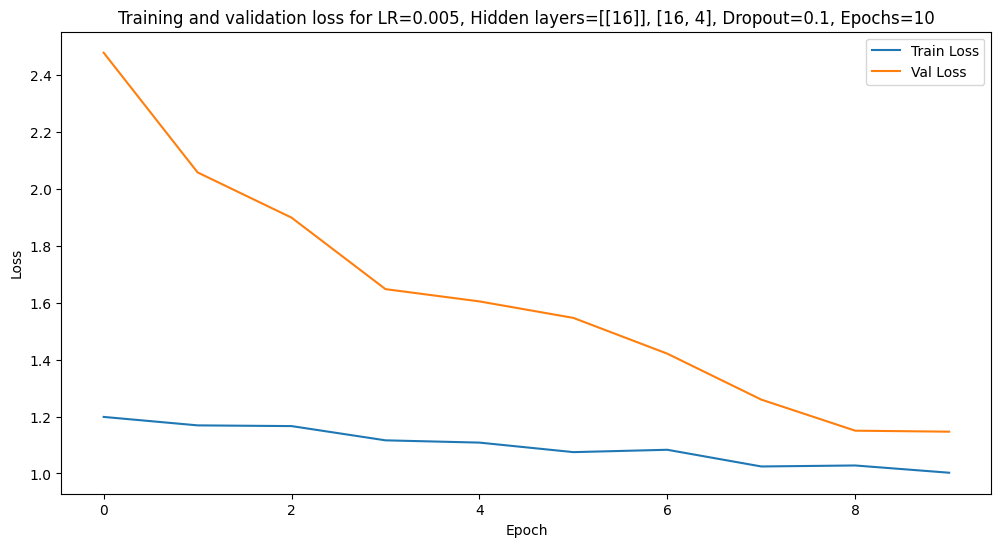

combination: LR=0.005, Local hidden layers=[16], Global hidden layers [16, 4], Dropout=0.1, Epochs=20
Final val accuracy: 1.0


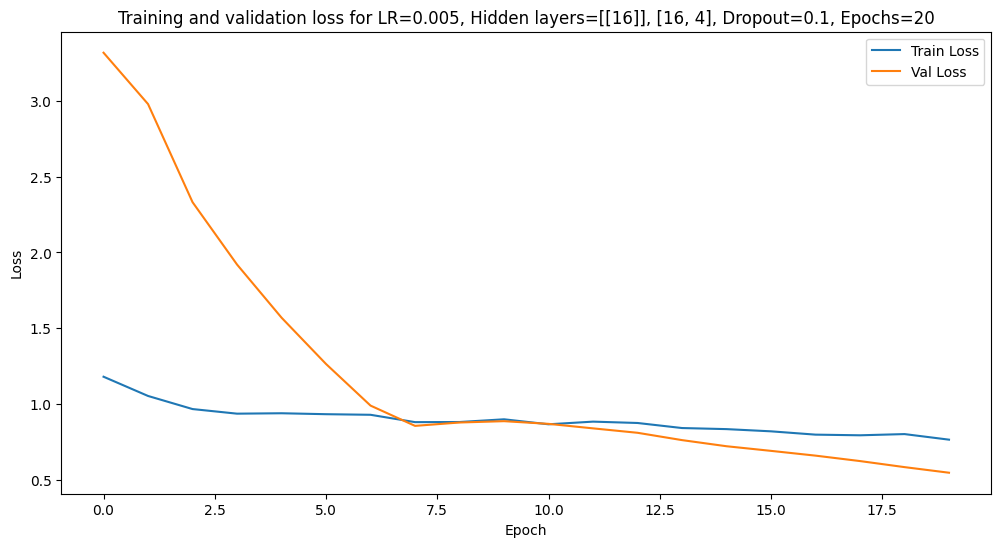

combination: LR=0.005, Local hidden layers=[16], Global hidden layers [16, 4], Dropout=0.1, Epochs=30
Final val accuracy: 1.0


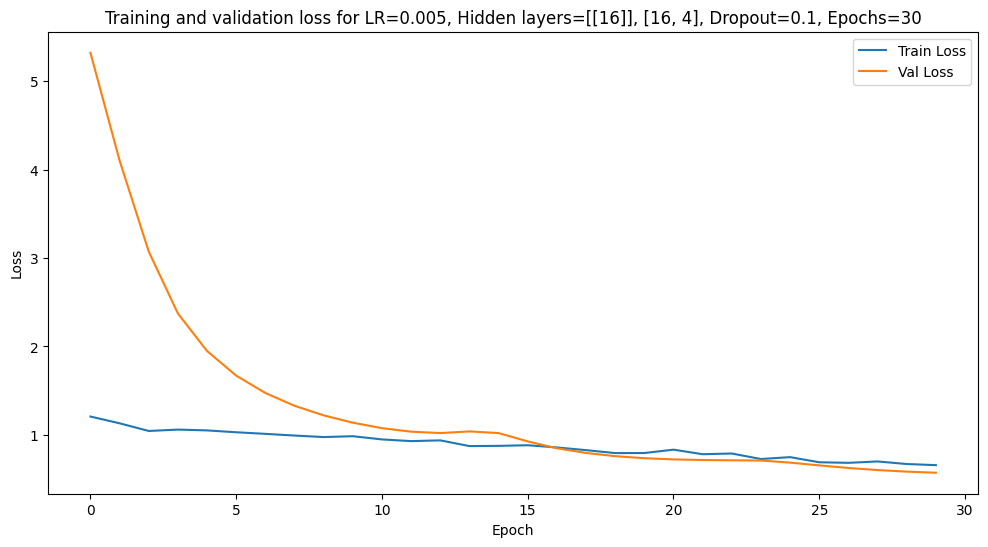

combination: LR=0.005, Local hidden layers=[32], Global hidden layers [32, 8], Dropout=0.0, Epochs=10
Final val accuracy: 1.0


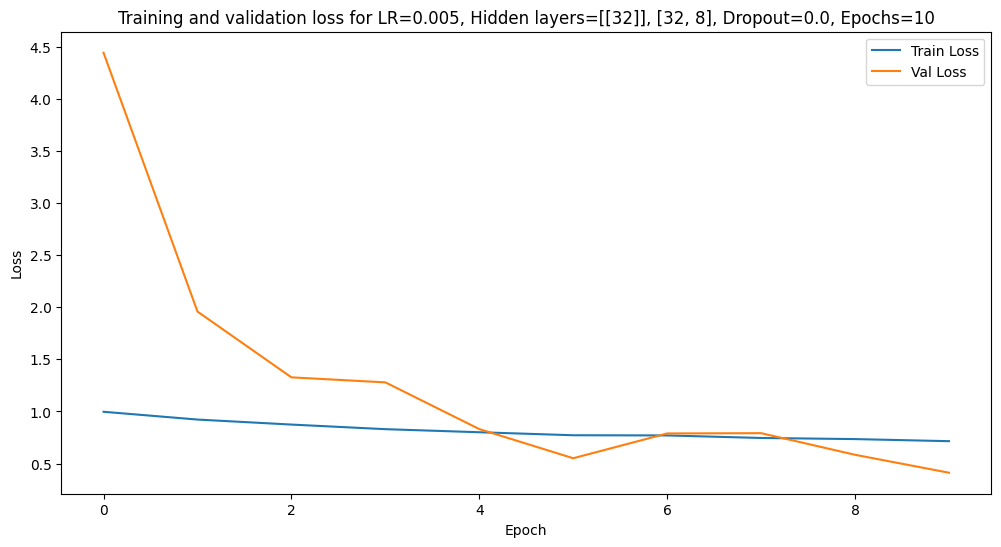

combination: LR=0.005, Local hidden layers=[32], Global hidden layers [32, 8], Dropout=0.0, Epochs=20
Final val accuracy: 1.0


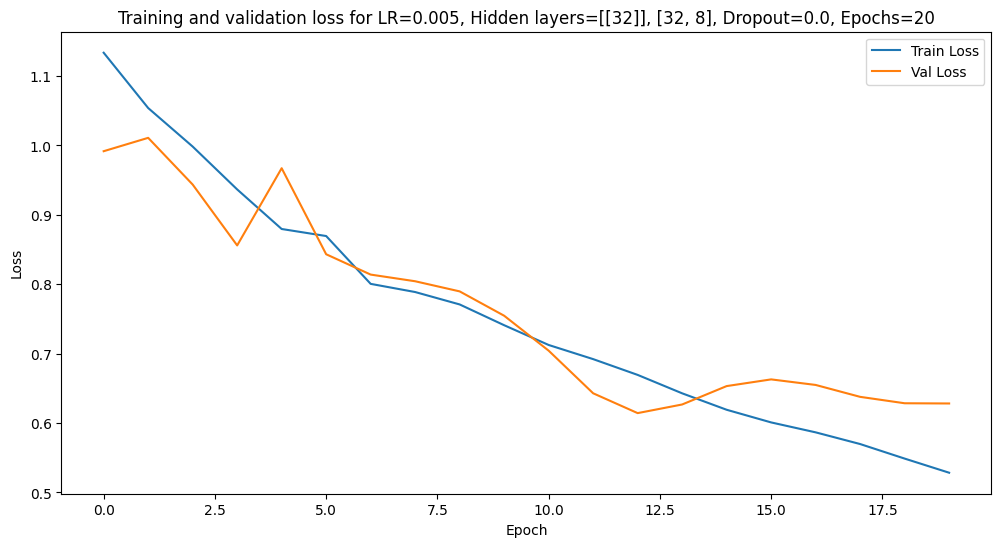

combination: LR=0.005, Local hidden layers=[32], Global hidden layers [32, 8], Dropout=0.0, Epochs=30
Final val accuracy: 1.0


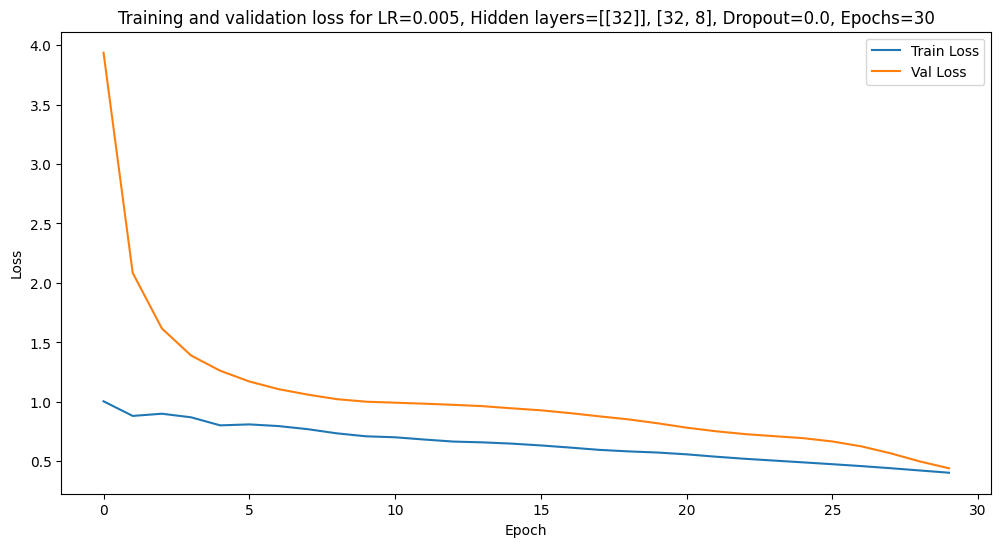

combination: LR=0.005, Local hidden layers=[32], Global hidden layers [32, 8], Dropout=0.1, Epochs=10
Final val accuracy: 0.8888888888888888


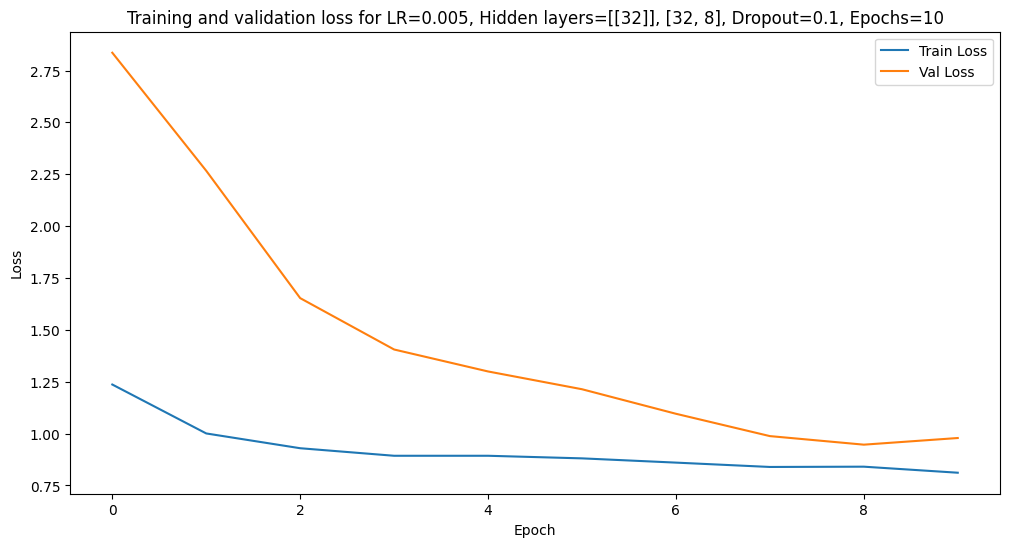

combination: LR=0.005, Local hidden layers=[32], Global hidden layers [32, 8], Dropout=0.1, Epochs=20
Final val accuracy: 1.0


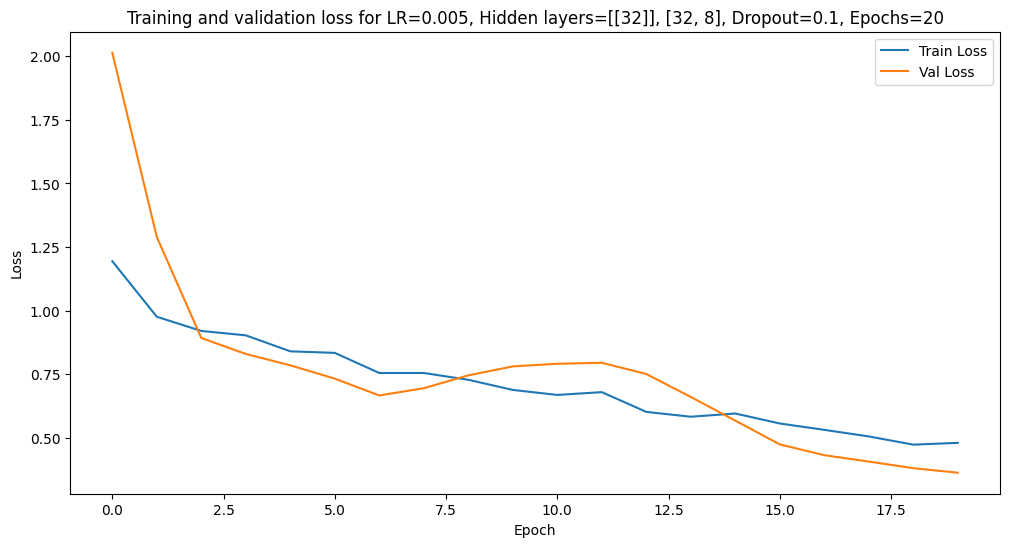

combination: LR=0.005, Local hidden layers=[32], Global hidden layers [32, 8], Dropout=0.1, Epochs=30
Final val accuracy: 1.0


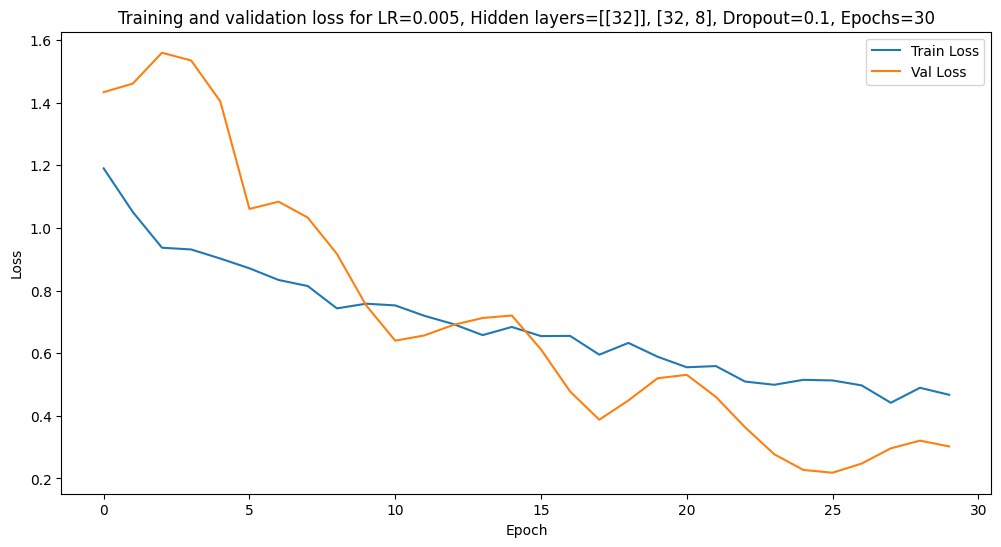

combination: LR=0.005, Local hidden layers=[32], Global hidden layers [32, 4], Dropout=0.0, Epochs=10
Final val accuracy: 0.0


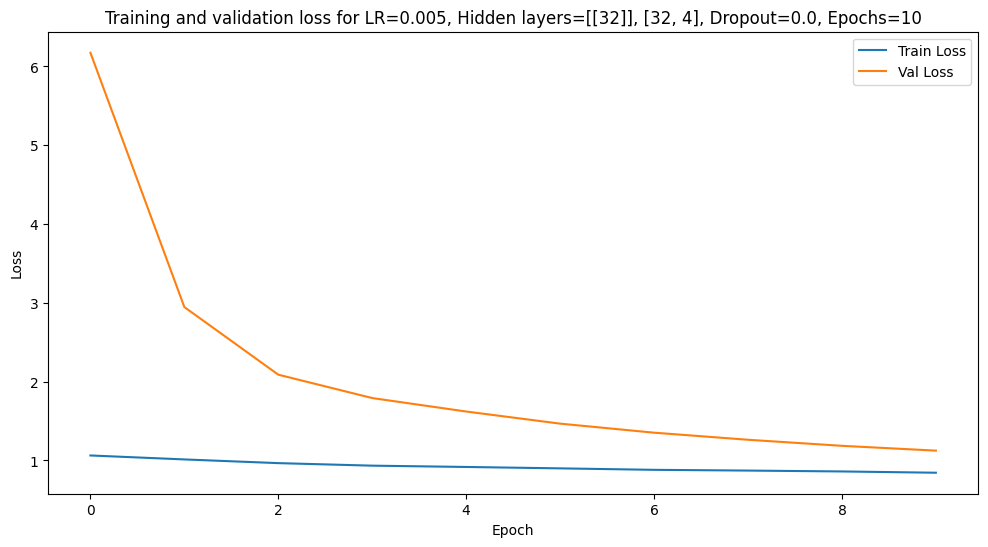

combination: LR=0.005, Local hidden layers=[32], Global hidden layers [32, 4], Dropout=0.0, Epochs=20
Final val accuracy: 1.0


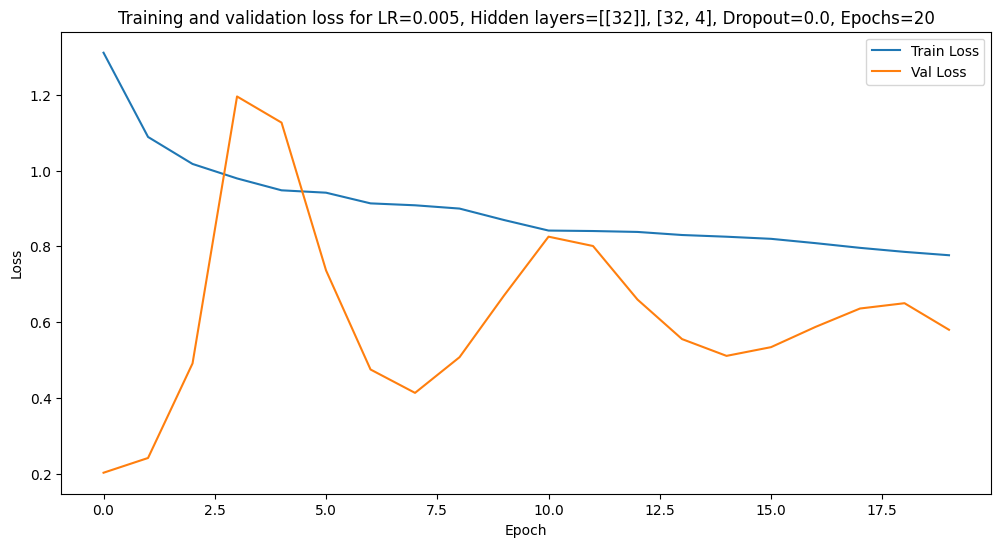

combination: LR=0.005, Local hidden layers=[32], Global hidden layers [32, 4], Dropout=0.0, Epochs=30
Final val accuracy: 0.0


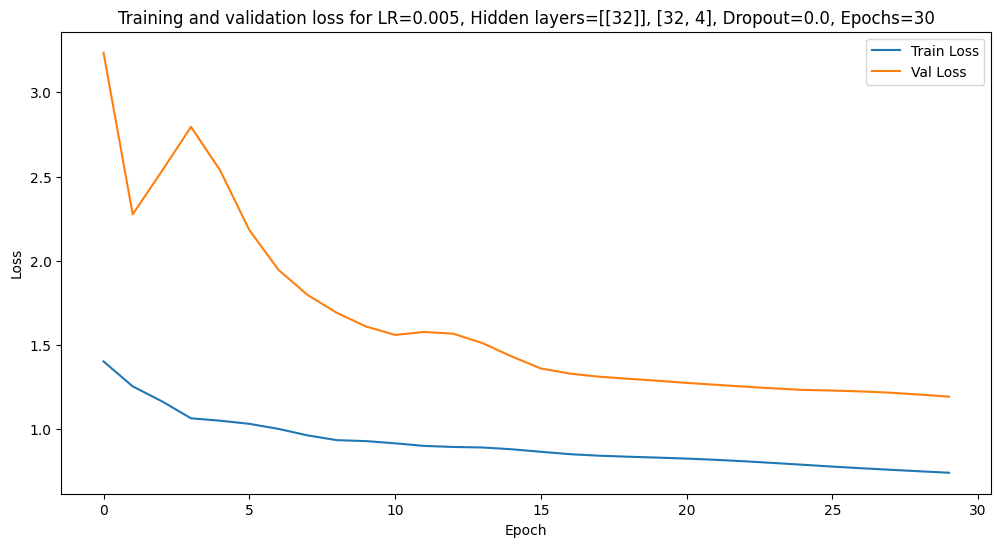

combination: LR=0.005, Local hidden layers=[32], Global hidden layers [32, 4], Dropout=0.1, Epochs=10
Final val accuracy: 0.0


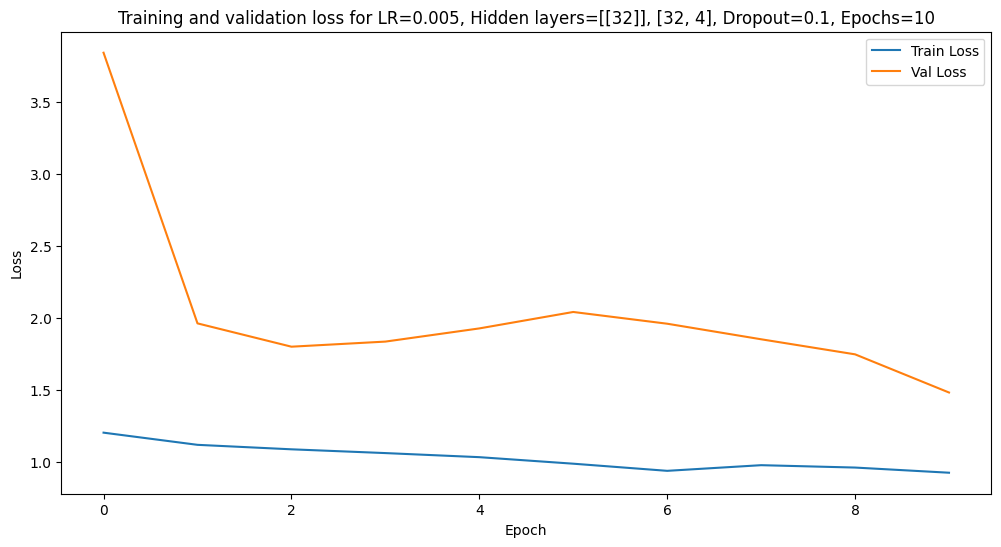

combination: LR=0.005, Local hidden layers=[32], Global hidden layers [32, 4], Dropout=0.1, Epochs=20
Final val accuracy: 0.8888888888888888


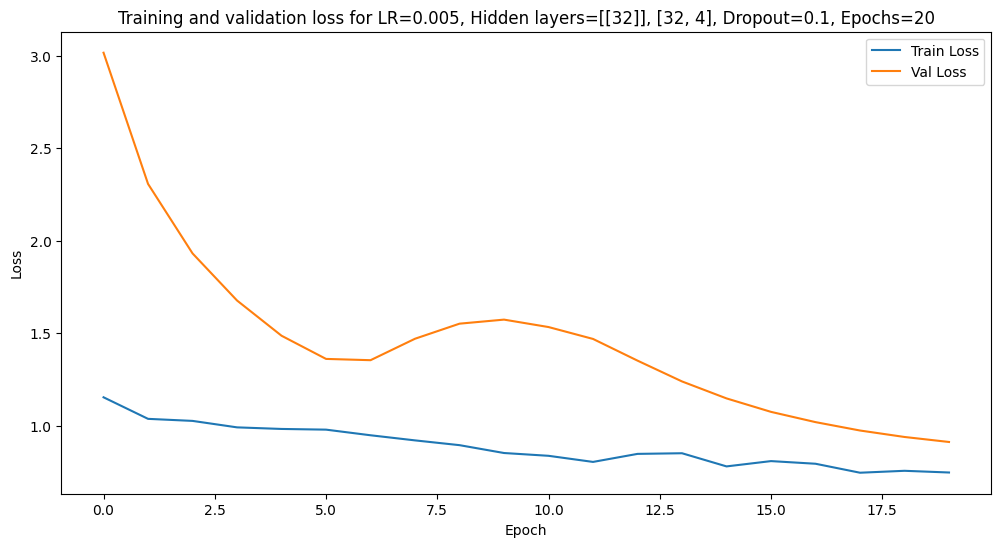

combination: LR=0.005, Local hidden layers=[32], Global hidden layers [32, 4], Dropout=0.1, Epochs=30
Final val accuracy: 1.0


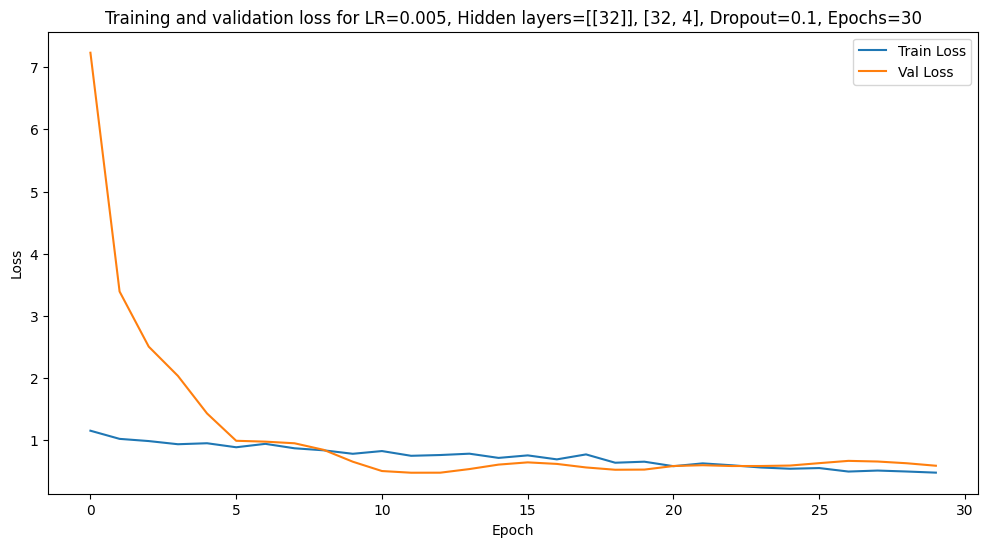

combination: LR=0.01, Local hidden layers=[16], Global hidden layers [16, 8], Dropout=0.0, Epochs=10
Final val accuracy: 0.5555555555555556


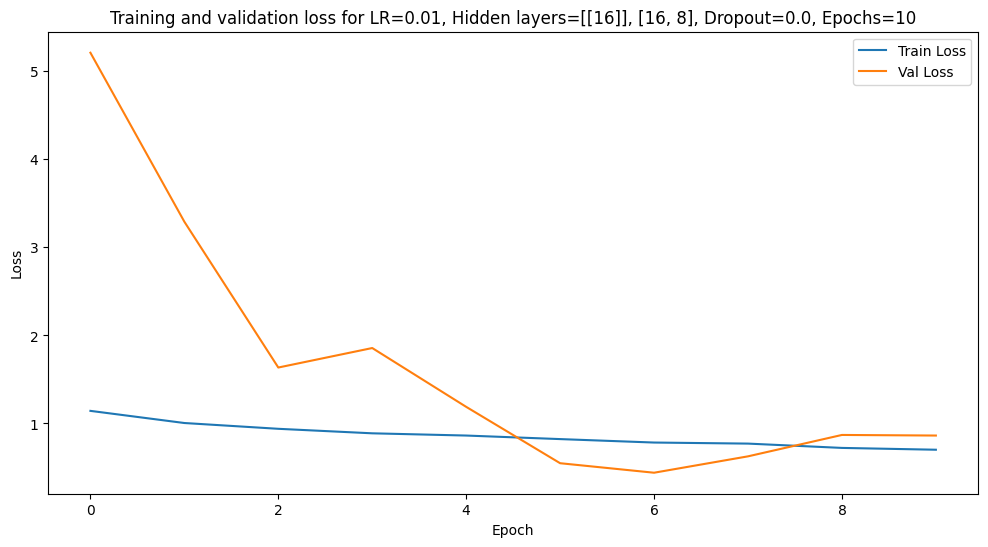

combination: LR=0.01, Local hidden layers=[16], Global hidden layers [16, 8], Dropout=0.0, Epochs=20
Final val accuracy: 1.0


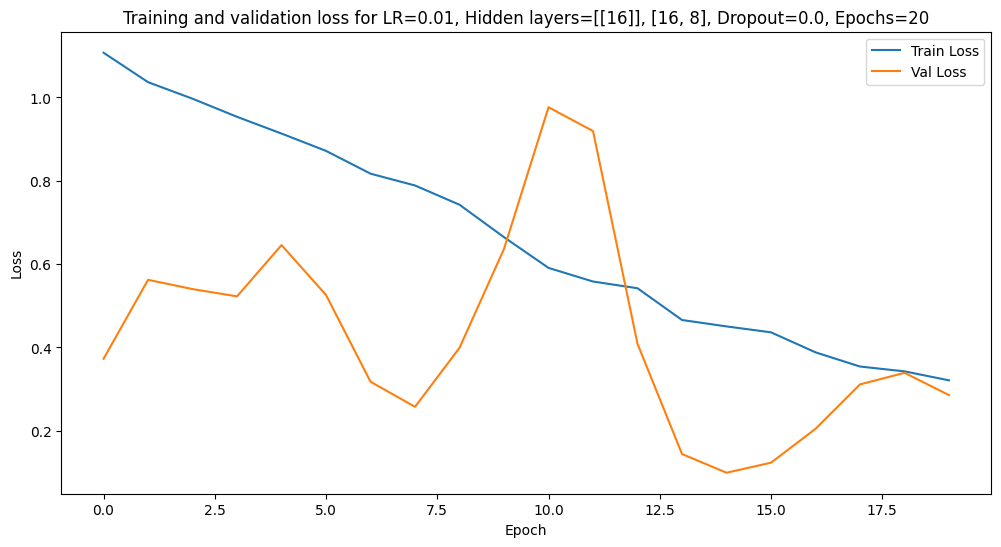

combination: LR=0.01, Local hidden layers=[16], Global hidden layers [16, 8], Dropout=0.0, Epochs=30
Final val accuracy: 1.0


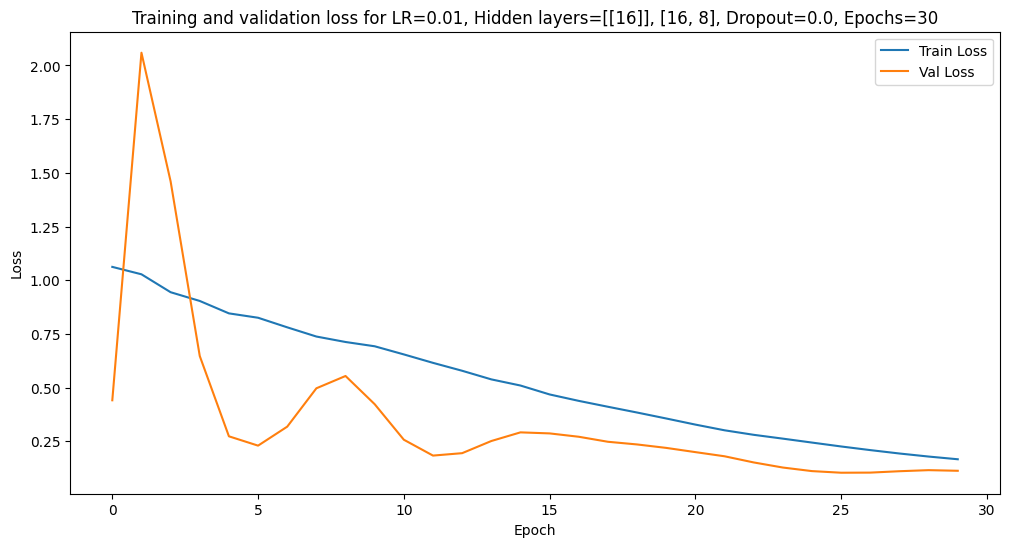

combination: LR=0.01, Local hidden layers=[16], Global hidden layers [16, 8], Dropout=0.1, Epochs=10
Final val accuracy: 0.0


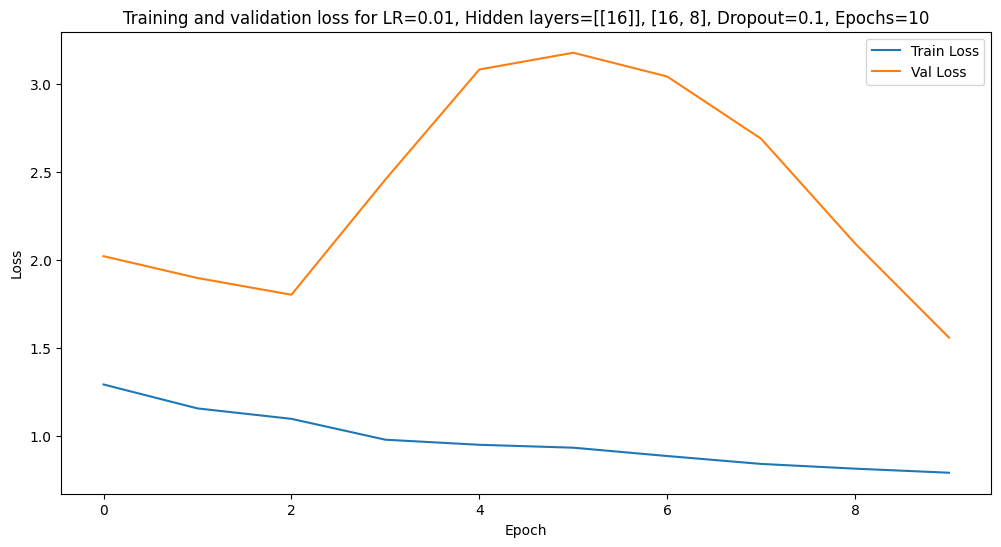

combination: LR=0.01, Local hidden layers=[16], Global hidden layers [16, 8], Dropout=0.1, Epochs=20
Final val accuracy: 0.7777777777777778


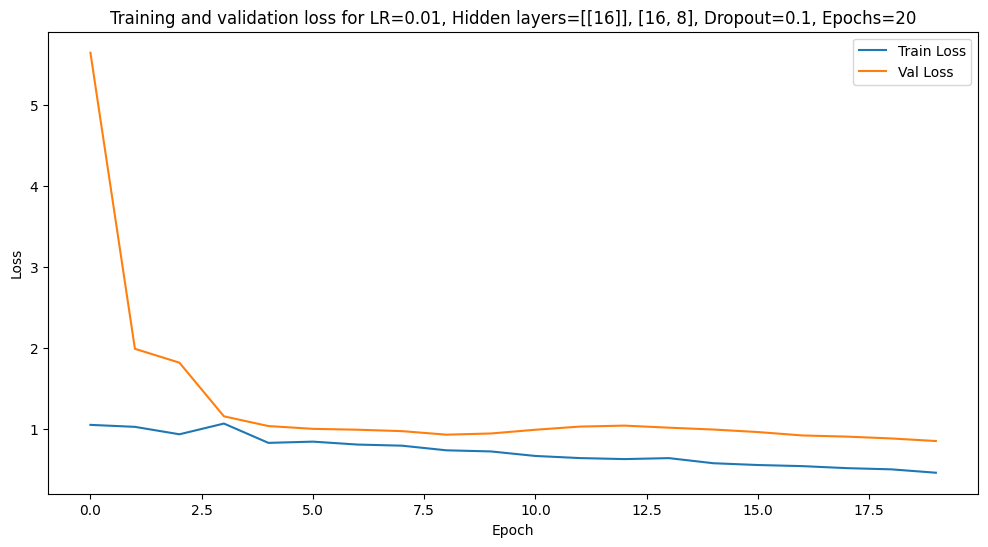

combination: LR=0.01, Local hidden layers=[16], Global hidden layers [16, 8], Dropout=0.1, Epochs=30
Final val accuracy: 1.0


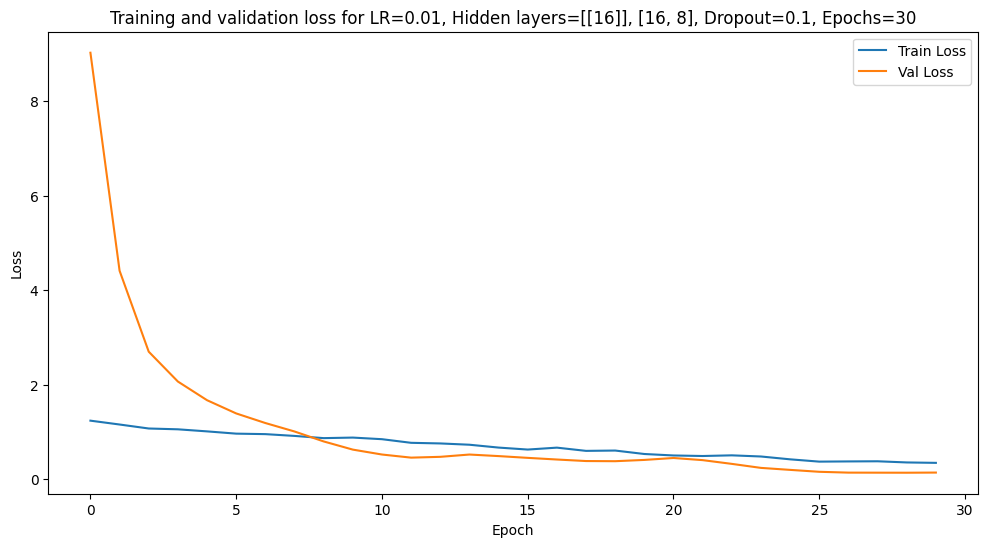

combination: LR=0.01, Local hidden layers=[16], Global hidden layers [16, 4], Dropout=0.0, Epochs=10
Final val accuracy: 0.8888888888888888


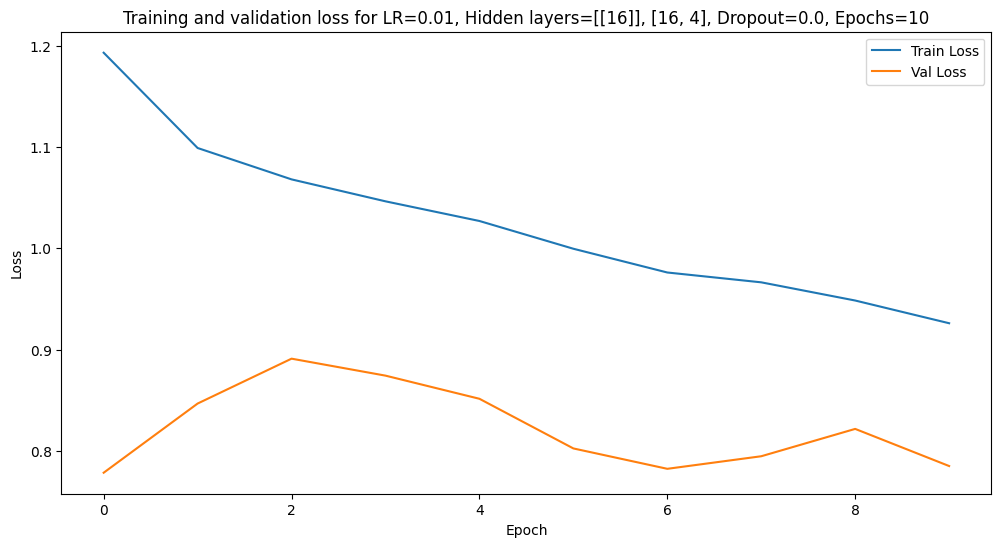

combination: LR=0.01, Local hidden layers=[16], Global hidden layers [16, 4], Dropout=0.0, Epochs=20
Final val accuracy: 1.0


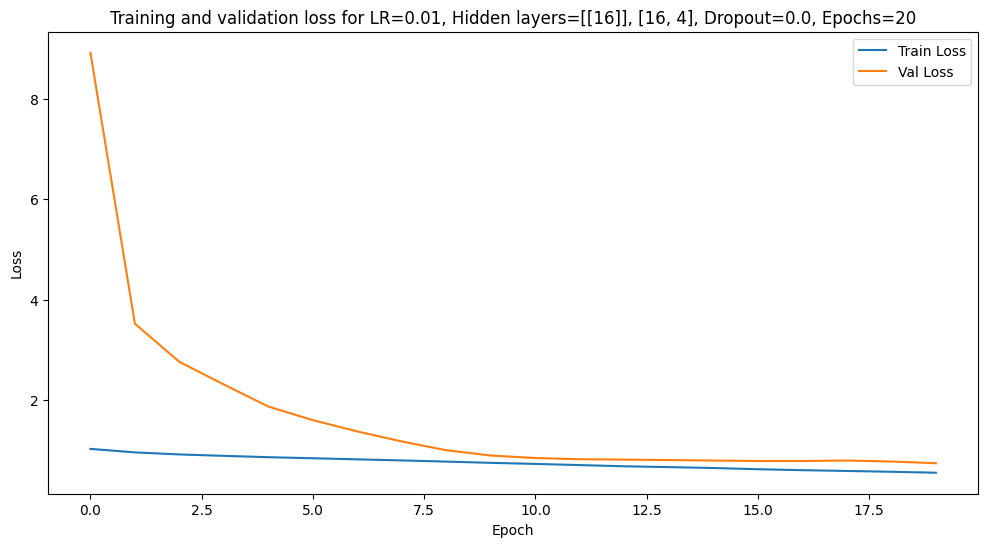

combination: LR=0.01, Local hidden layers=[16], Global hidden layers [16, 4], Dropout=0.0, Epochs=30
Final val accuracy: 1.0


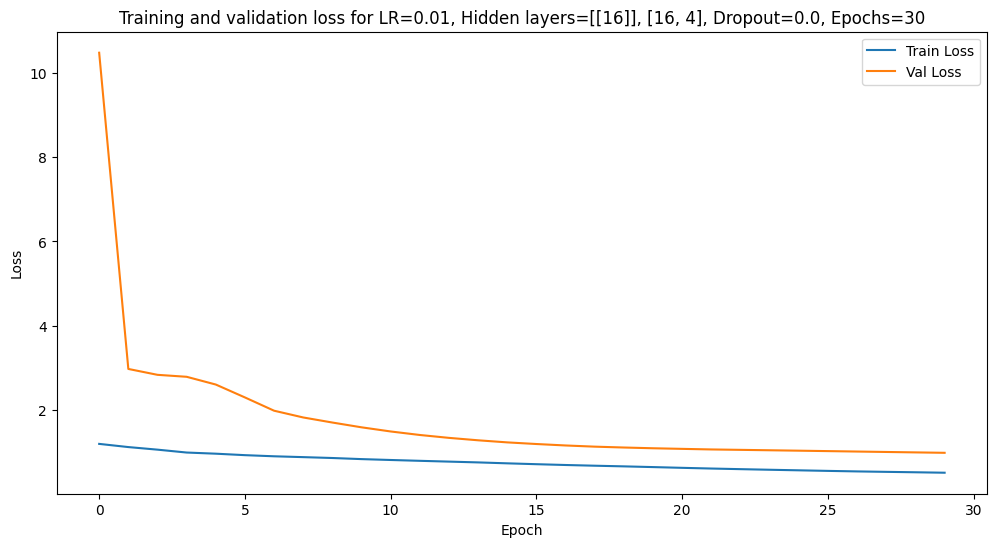

combination: LR=0.01, Local hidden layers=[16], Global hidden layers [16, 4], Dropout=0.1, Epochs=10
Final val accuracy: 0.8888888888888888


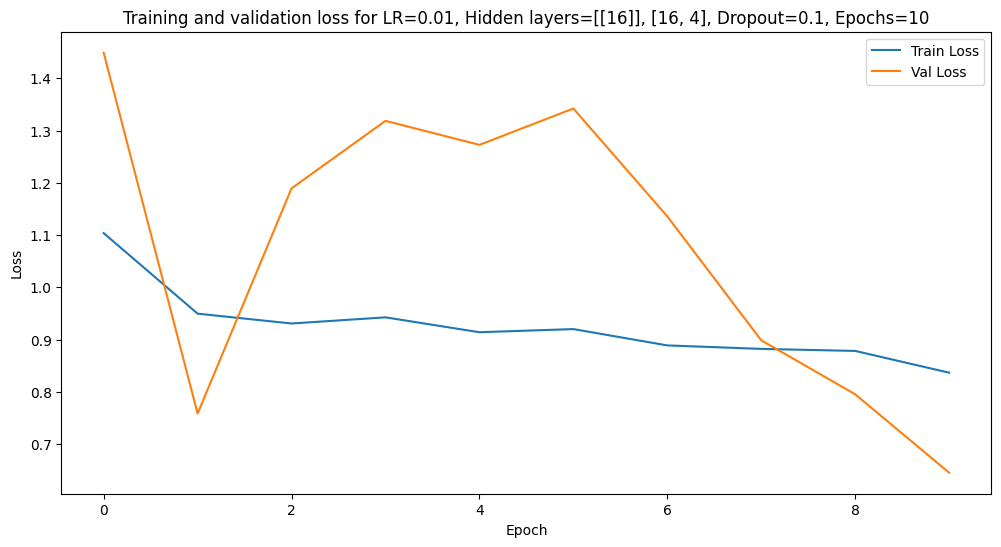

combination: LR=0.01, Local hidden layers=[16], Global hidden layers [16, 4], Dropout=0.1, Epochs=20
Final val accuracy: 1.0


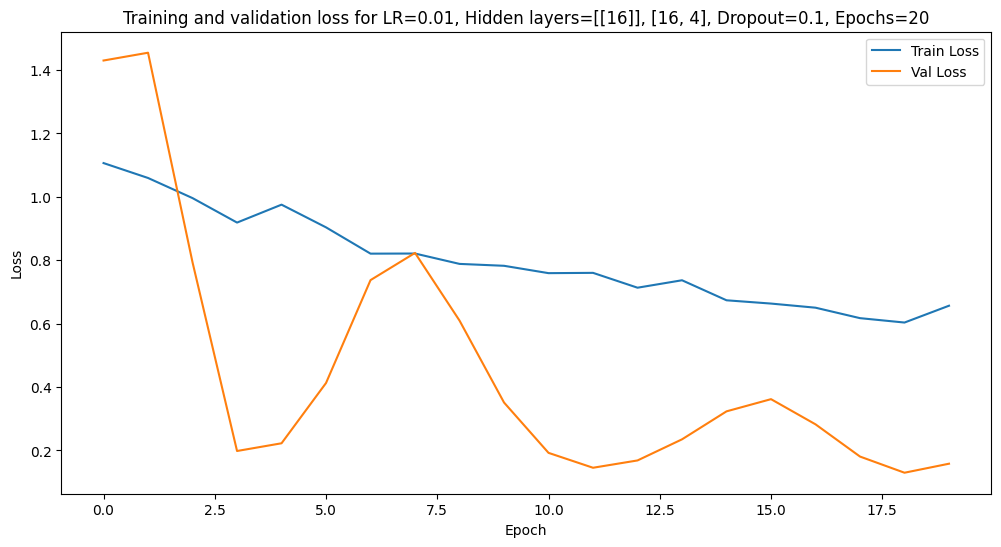

combination: LR=0.01, Local hidden layers=[16], Global hidden layers [16, 4], Dropout=0.1, Epochs=30
Final val accuracy: 1.0


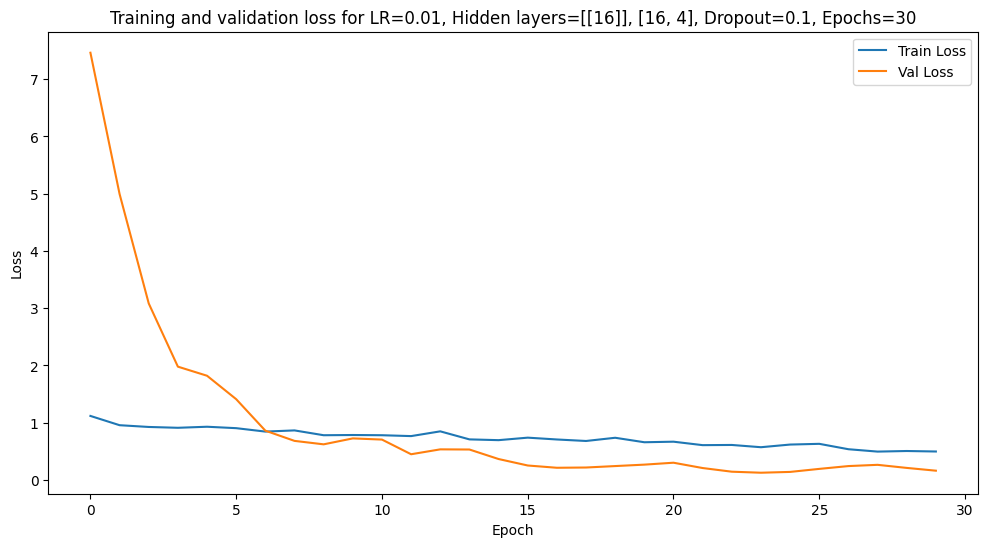

combination: LR=0.01, Local hidden layers=[32], Global hidden layers [32, 8], Dropout=0.0, Epochs=10
Final val accuracy: 0.8888888888888888


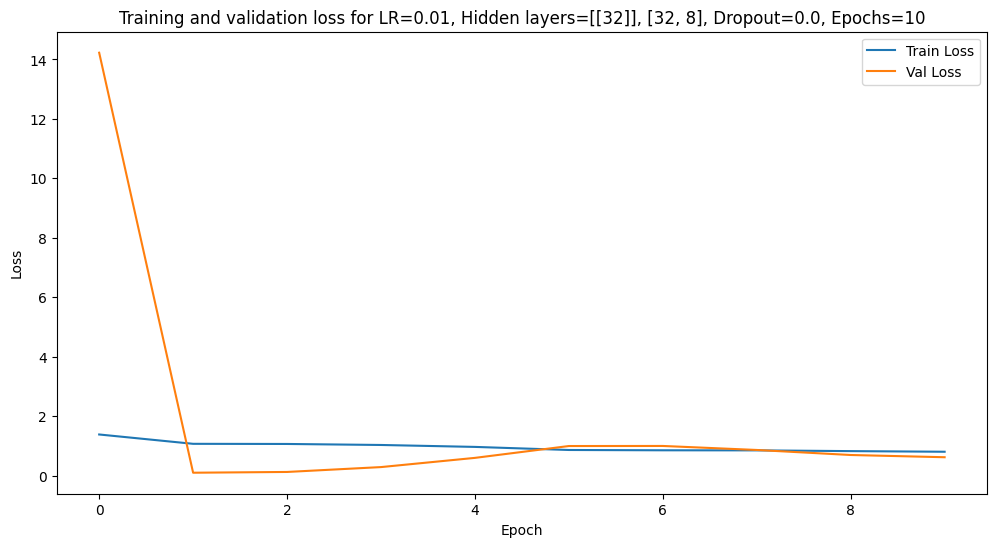

combination: LR=0.01, Local hidden layers=[32], Global hidden layers [32, 8], Dropout=0.0, Epochs=20
Final val accuracy: 1.0


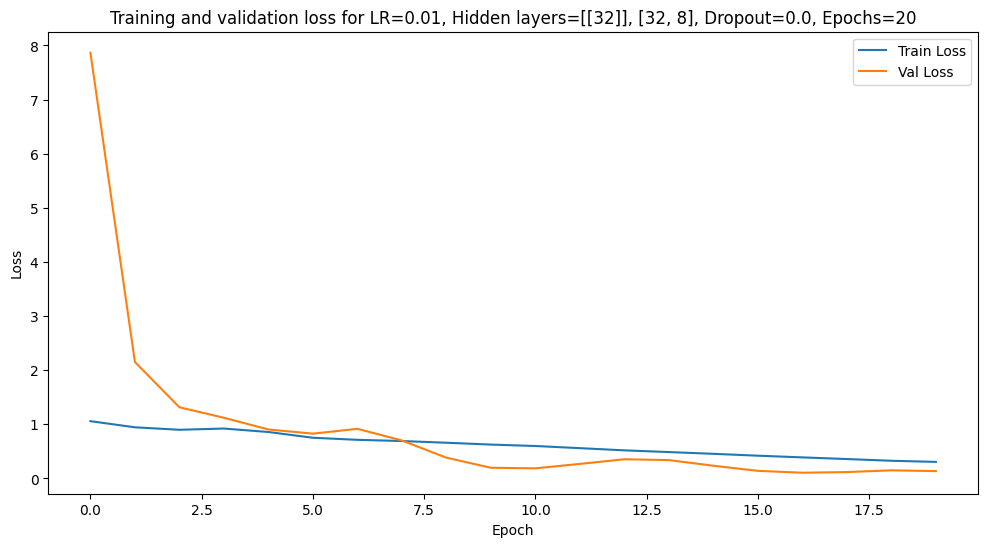

combination: LR=0.01, Local hidden layers=[32], Global hidden layers [32, 8], Dropout=0.0, Epochs=30
Final val accuracy: 1.0


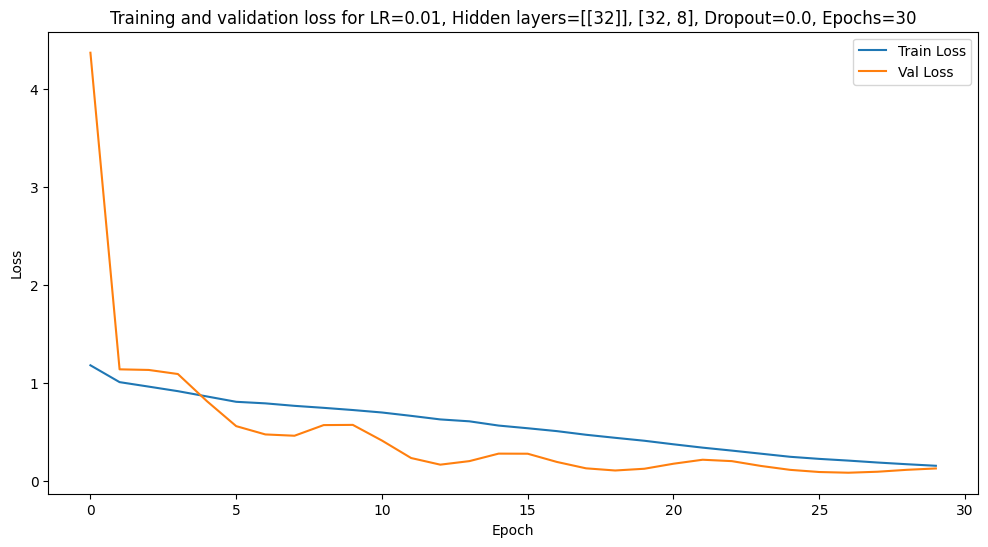

combination: LR=0.01, Local hidden layers=[32], Global hidden layers [32, 8], Dropout=0.1, Epochs=10
Final val accuracy: 0.8888888888888888


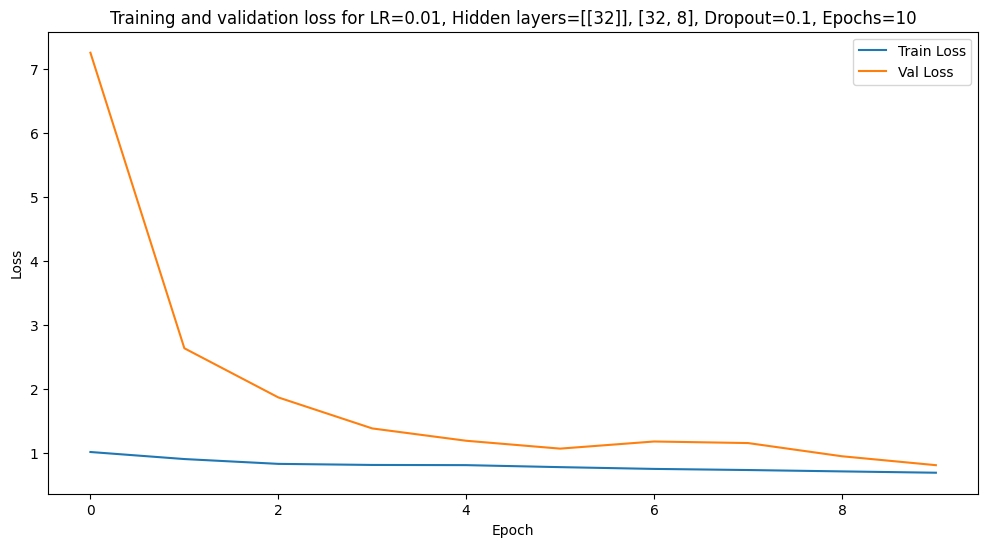

combination: LR=0.01, Local hidden layers=[32], Global hidden layers [32, 8], Dropout=0.1, Epochs=20
Final val accuracy: 1.0


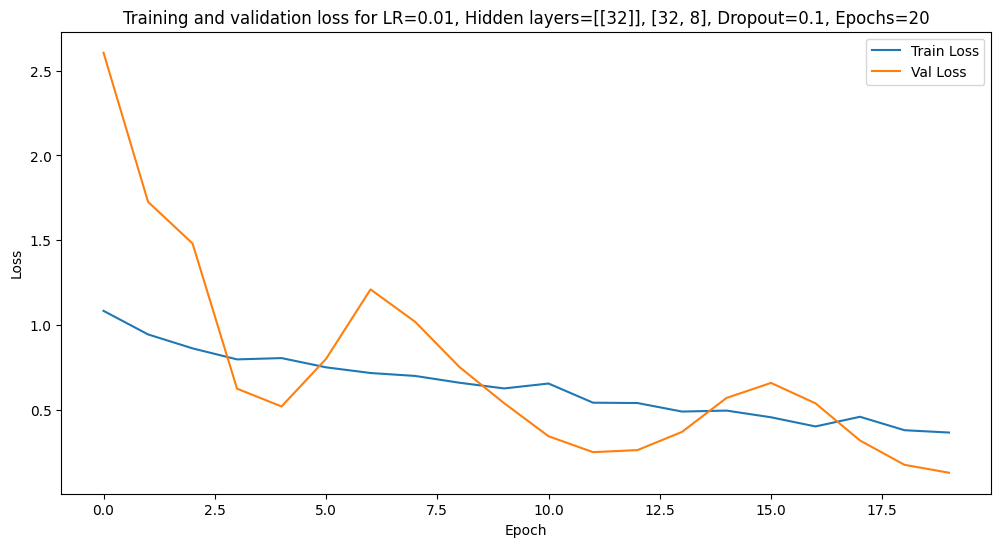

combination: LR=0.01, Local hidden layers=[32], Global hidden layers [32, 8], Dropout=0.1, Epochs=30
Final val accuracy: 1.0


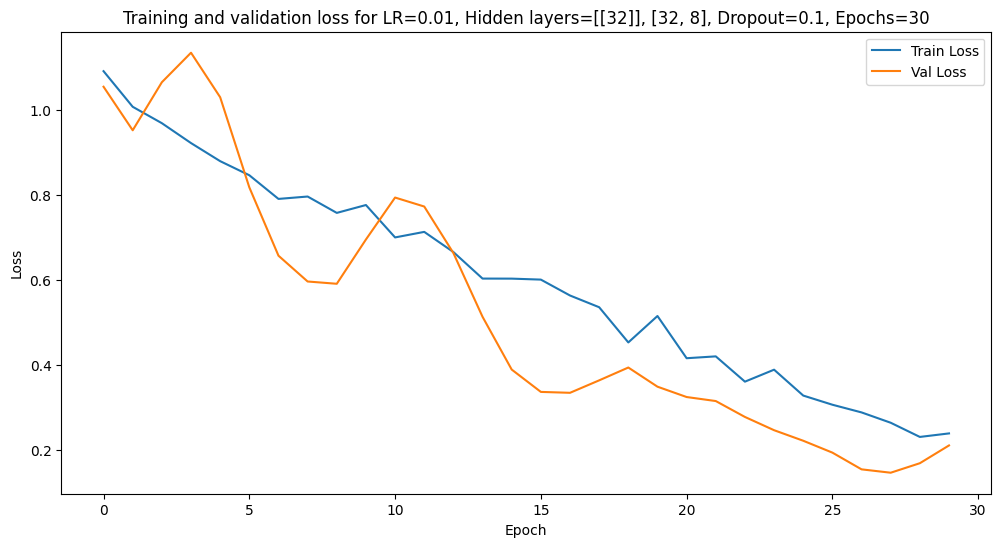

combination: LR=0.01, Local hidden layers=[32], Global hidden layers [32, 4], Dropout=0.0, Epochs=10
Final val accuracy: 1.0


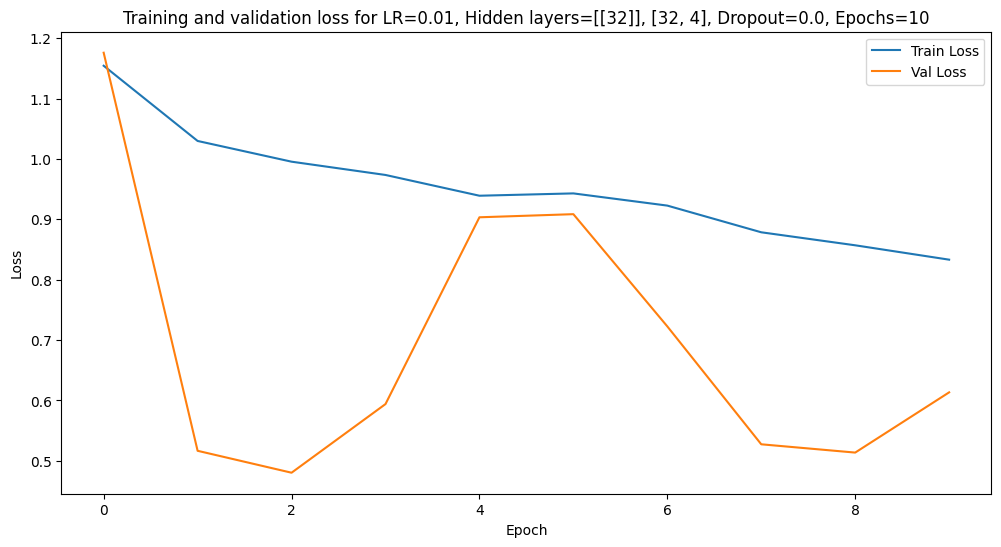

combination: LR=0.01, Local hidden layers=[32], Global hidden layers [32, 4], Dropout=0.0, Epochs=20
Final val accuracy: 0.0


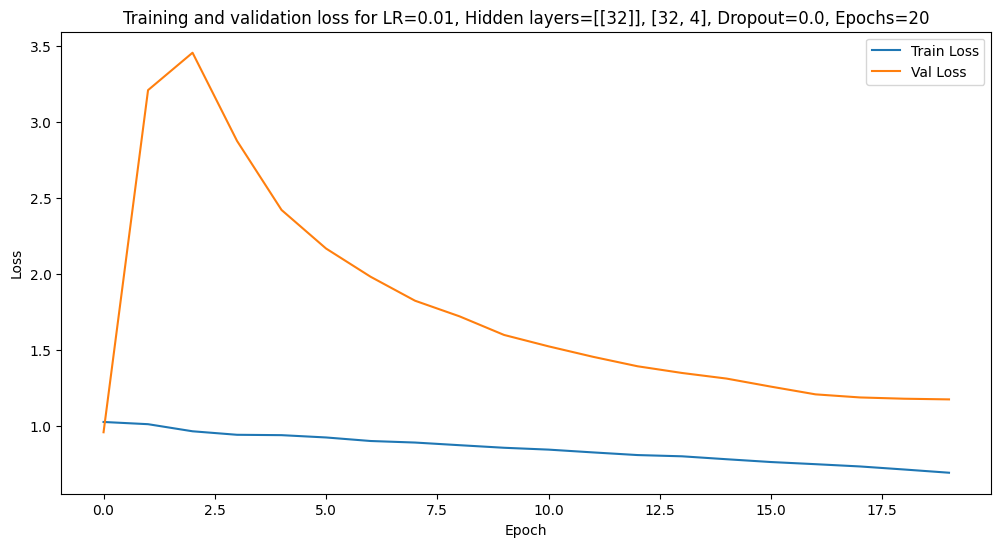

combination: LR=0.01, Local hidden layers=[32], Global hidden layers [32, 4], Dropout=0.0, Epochs=30
Final val accuracy: 1.0


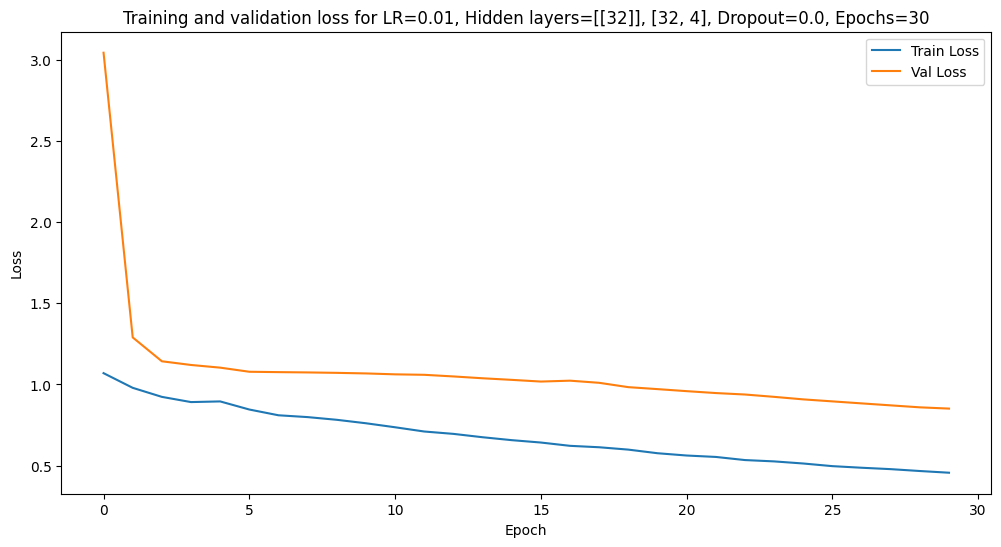

combination: LR=0.01, Local hidden layers=[32], Global hidden layers [32, 4], Dropout=0.1, Epochs=10
Final val accuracy: 0.3333333333333333


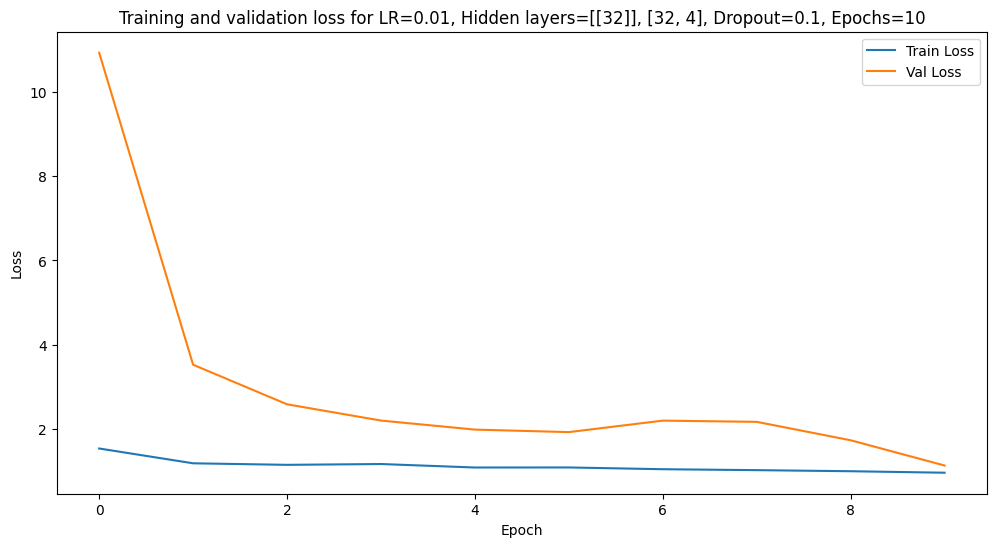

combination: LR=0.01, Local hidden layers=[32], Global hidden layers [32, 4], Dropout=0.1, Epochs=20
Final val accuracy: 0.0


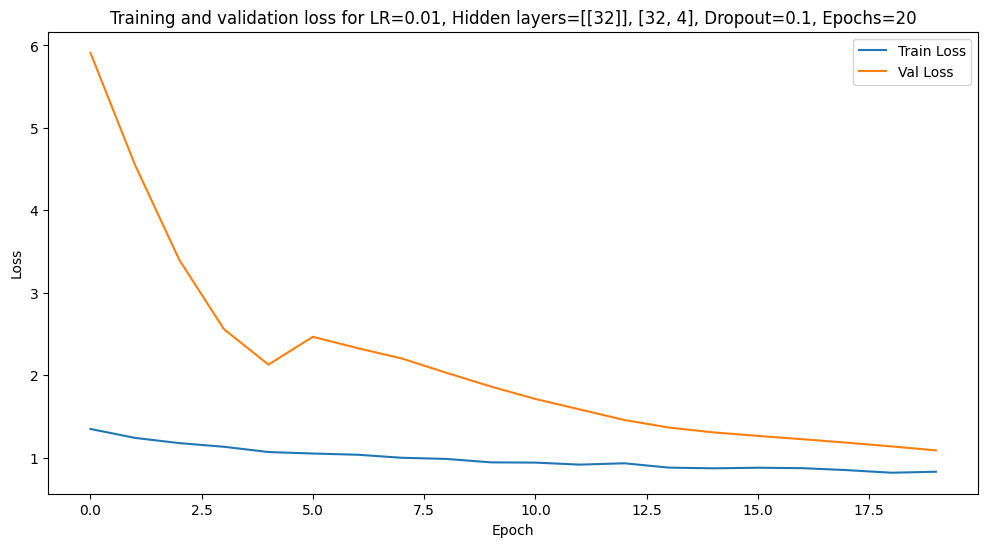

combination: LR=0.01, Local hidden layers=[32], Global hidden layers [32, 4], Dropout=0.1, Epochs=30
Final val accuracy: 1.0


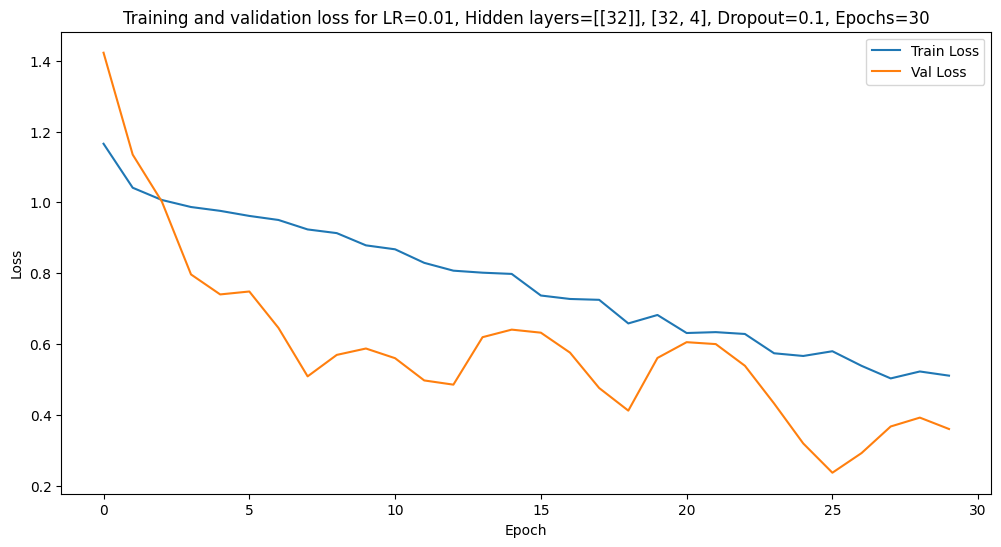

In [45]:
for lr, local_hidden_size, global_hidden_size, dropout, epochs in product(learning_rates, local_hidden_layer_sizes, global_hidden_layer_sizes, dropout_rates, epochs_list): # grid search and saving all models and results
    print(f'combination: LR={lr}, Local hidden layers={local_hidden_size}, Global hidden layers {[local_hidden_size[-1]] + global_hidden_size}, Dropout={dropout}, Epochs={epochs}')
    train_losses, val_losses, val_patient_accuracy, aggregation, = train_model(local_hidden_size, global_hidden_size, dropout, lr, epochs)
    results.append((lr, local_hidden_size,global_hidden_size, dropout, epochs, val_patient_accuracy))

    print(f'Final val accuracy: {val_patient_accuracy}')

    plt.figure(figsize=(12, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Training and validation loss for LR={lr}, Hidden layers=[{local_hidden_size}], {[local_hidden_size[-1]] + global_hidden_size}, Dropout={dropout}, Epochs={epochs}')
    plt.show()

    # save model for later use and evaluation
    model_save_path = f'aggregation_model_{lr}_[{local_hidden_size}][{[local_hidden_size[-1]] + global_hidden_size}]_{dropout}_{epochs}.pt'
    hyperparameters = {'lr': lr, 'local_hidden_sizes': local_hidden_size, 'global_hidden_layer_sizes': global_hidden_size, 'dropout': dropout, 'epochs': epochs}
    torch.save({'model': aggregation.state_dict(), 'hyperparameters': hyperparameters}, model_save_path)

In [55]:
best_models = [m for m in results if m[-1] == 1.0]

In [56]:
def sort_key(model):
    lr, local, global_, dropout, epochs, acc = model
    total_layers = len(local) + len(global_)
    total_size = sum(local) + sum(global_)
    return (total_layers, total_size, epochs, dropout, lr)

In [59]:
simplest_models = sorted(best_models, key=sort_key)

final_model = simplest_models[0]

final_model_path = f'aggregation_model_{final_model[0]}_[{final_model[1]}][{[final_model[1][-1]] + final_model[2]}]_{final_model[3]}_{final_model[4]}.pt'

In [63]:
checkpoint = torch.load(final_model_path)
hyperparameters = checkpoint['hyperparameters']

model = initialize_model(features, hyperparameters['local_hidden_sizes'], hyperparameters['global_hidden_layer_sizes'], hyperparameters['dropout'])
model.load_state_dict(checkpoint['model'])
model.eval()

C:\Users\normal\AppData\Local\Temp\ipykernel_3888\3097516229.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(final_model_path)


DeepSetsAggregation(local_nn=MLP(41, 16), global_nn=MLP(16, 4, 3))

In [64]:
test_features = torch.tensor(test[marker_columns].values, dtype=torch.float)
test_labels = torch.tensor(test['group'].values, dtype=torch.long)
test_ids = torch.tensor(test['id_numeric'].values, dtype=torch.long)

test_unique_ids = torch.unique(test_ids)
test_id_to_batch = {id_val.item(): i for i, id_val in enumerate(test_unique_ids)}
test_batch_indices = torch.tensor([test_id_to_batch[id_val.item()] for id_val in test_ids], dtype=torch.long)

In [65]:
with torch.no_grad():
    test_outputs = model(test_features, index=test_batch_indices)
    test_preds = test_outputs.argmax(dim=1)

    test_batch_labels = torch.tensor(
        [test_labels[test_ids == id_val].mode().values.item() for id_val in test_unique_ids],
        dtype=torch.long
    )

    test_accuracy = (test_preds == test_batch_labels).sum().item() / len(test_batch_labels)
    print(f'Test Accuracy: {test_accuracy:.4f}')

Test Accuracy: 0.5000


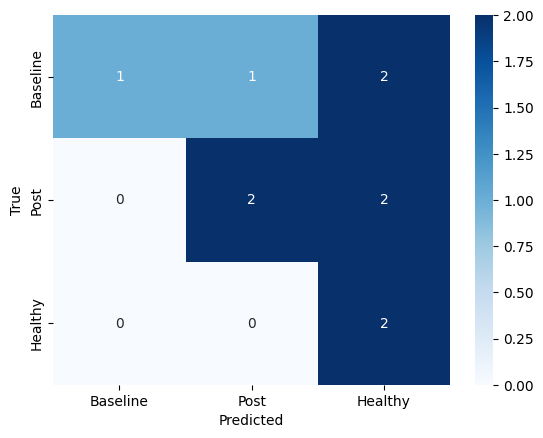

In [66]:
cm = confusion_matrix(test_batch_labels, test_preds)
seaborn.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Baseline', 'Post', 'Healthy'], yticklabels=['Baseline', 'Post', 'Healthy'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [67]:
def compute_feature_importance(model, features, labels, batch_indices): 
    model.eval()  
    unique_ids = torch.unique(batch_indices)
    batch_labels = torch.tensor(
        [labels[batch_indices == id_val].unique().item() for id_val in unique_ids],
        dtype=torch.long
    )
    
    with torch.no_grad():
        original_predictions = model(features, index=batch_indices)
        original_loss = cross_entropy(original_predictions, batch_labels)
    
    importances = []
    for i in range(features.shape[1]):
        permuted_features = features.clone()
        permuted_features[:, i] = permuted_features[torch.randperm(features.size(0)), i]
        
        with torch.no_grad():
            permuted_predictions = model(permuted_features, index=batch_indices)
            permuted_loss = cross_entropy(permuted_predictions, batch_labels)
        
        importance = permuted_loss - original_loss
        importances.append(importance.item())
    
    return np.array(importances)

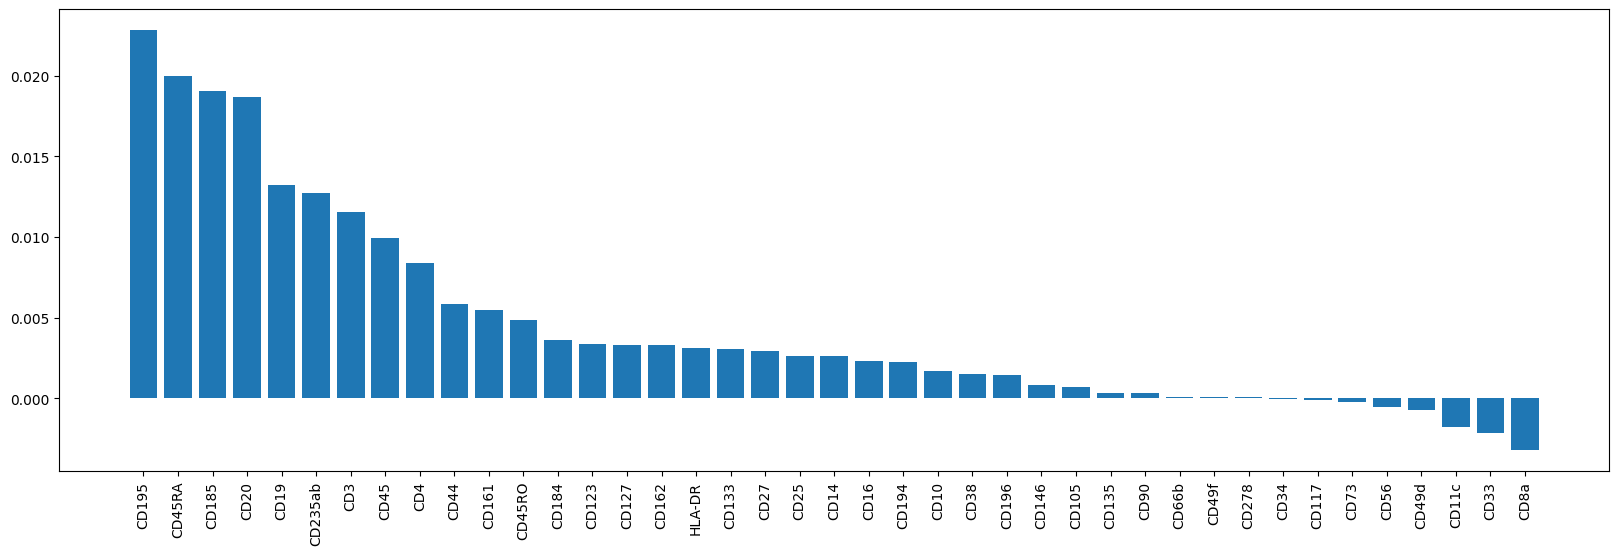

In [69]:
feature_importances = compute_feature_importance(model, features, labels, batch_indices)

indices = np.argsort(feature_importances)[::-1]
feature_names = train[marker_columns].columns

plt.figure(figsize=(20, 6))
plt.bar(range(len(feature_importances)), feature_importances[indices], align="center")
plt.xticks(range(len(feature_importances)), feature_names[indices], rotation=90)
plt.show()